In [ ]:

import warnings
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from matplotlib.patches import Patch
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy.stats import mannwhitneyu, chi2_contingency, spearmanr

from sklearn.model_selection import (
    StratifiedKFold,
    train_test_split,
    GridSearchCV,
    cross_val_score
)
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    precision_recall_curve,
    auc,
    recall_score,
    precision_score
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from itertools import combinations

warnings.filterwarnings('ignore')
np.random.seed(1234)

In [639]:
df = pd.read_csv('../rotterdam.csv')
df = df.dropna()

## Variable Selection Rationale

**Cohort definition:**
- **Node-zero** only (`nodes == 0`)
- **ER+** only (`er > 10`)

Because these are fixed inclusion criteria, variables tied to them are not used as predictors.

**Excluded Variables:**
- **`year`**: Time of surgery (enrollment year) is excluded because we're building a predictive model based on patient characteristics and tumor biology, not temporal trends.
- **`hospital_id`**, **`pid`**: Patient/hospital identifiers are excluded as they do not represent clinical features.
- **`meno` (menopausal status)**: Excluded to keep the model focused on tumor biology and treatment variables within the node-zero ER+ cohort.
- **`er`**: since estrogen receptor value can be considered positive if greater than 10, this data is therefore uninformative in the ER+ cohort.
- **`hormon`**, **`chemo`**: treatment indicators are not significant in this cohort as this subgroup didn't receive any treatment

**Included Variables:**
- **Clinical/pathological features**: age, grade, size
- **Biological markers**: pgr

In [640]:
CUTOFF_DAYS = 365 * 5

# Recurrence is defined as early recurrence (within 5 years)
df['target'] = np.where((df['recur'] == 1) & (df['rtime'] <= CUTOFF_DAYS), 1, 0)

# Keep:
# - early recurrences (within cutoff)
# - non-recurrences with sufficient follow-up (not censored before cutoff)
valid_mask = (
    (df['nodes'] == 0) &
    (df['er'] > 10) &
    (
        (df['target'] == 1) |
        ((df['recur'] == 0) & (df['rtime'] >= CUTOFF_DAYS))
    )
)

df_clean = df[valid_mask].copy()

print(f"Original shape: {df.shape}")
print(f"Shape after filtering (follow-up >= 5y): {df_clean.shape}")

summary = pd.DataFrame({
    'Count': df_clean['target'].value_counts(),
    'Proportion': df_clean['target'].value_counts(normalize=True).round(3)
})
print("\nRecurrence summary:\n")
print(summary)

Original shape: (2982, 17)
Shape after filtering (follow-up >= 5y): (570, 17)

Recurrence summary:

        Count  Proportion
target                   
0         448       0.786
1         122       0.214



Numeric feature summary:
         mean     std   min   25%    50%     75%     max
age     56.14   12.71  25.0  46.0   56.0   66.00    87.0
pgr    238.26  327.32   0.0  25.0  113.0  329.75  2596.0
grade    2.65    0.48   2.0   2.0    3.0    3.00     3.0


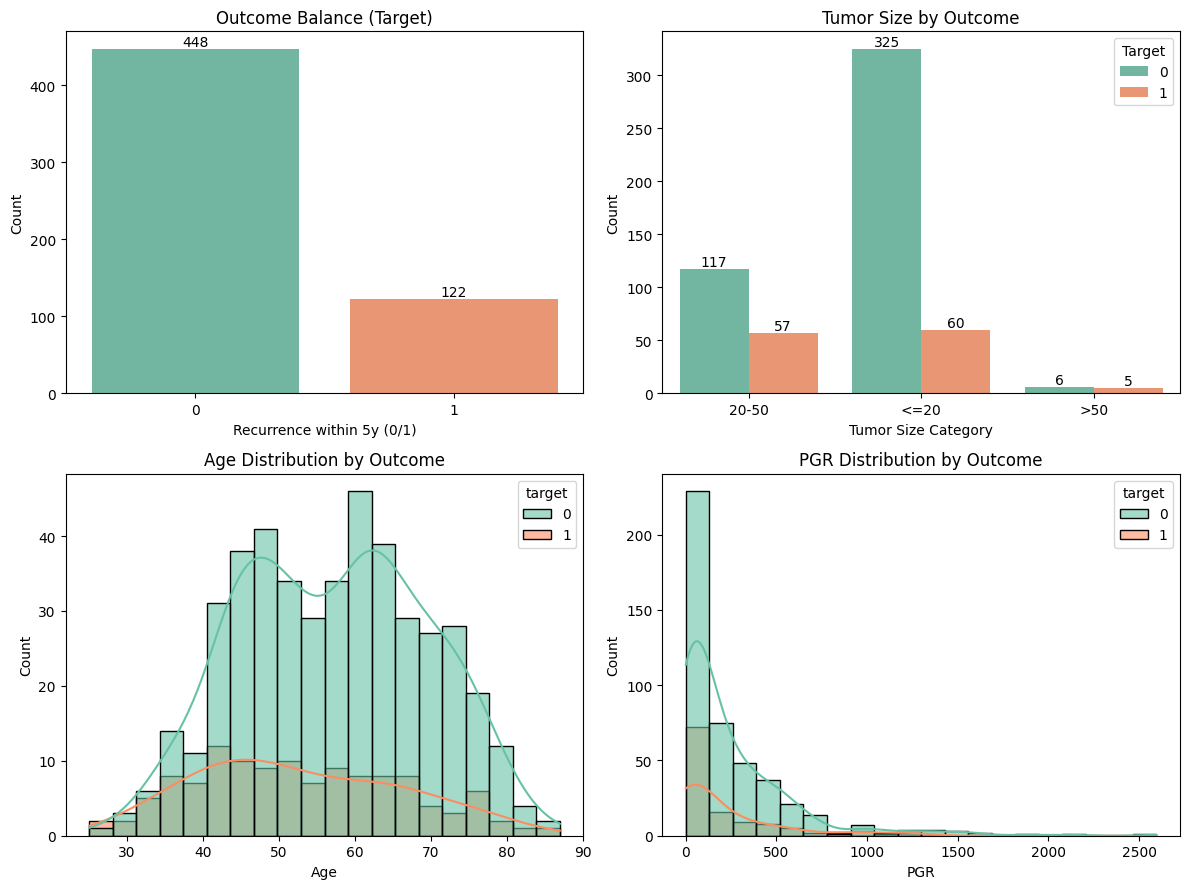

In [682]:
df_clean['pgr_cat'] = np.where(df_clean['pgr'] > 10, 1, 0)

summary_cols = ['age', 'pgr', 'grade']
desc = df_clean[summary_cols].describe().T[['mean', 'std', 'min', '25%', '50%', '75%', 'max']]
print("\nNumeric feature summary:")
print(desc.round(2).to_string())

fig, axes = plt.subplots(2, 2, figsize=(12, 9))
axes = axes.flatten()

sns.countplot(x='target', data=df_clean, ax=axes[0], palette='Set2')
axes[0].set_title('Outcome Balance (Target)')
axes[0].set_xlabel('Recurrence within 5y (0/1)')
axes[0].set_ylabel('Count')
for container in axes[0].containers:
    axes[0].bar_label(container)

sns.countplot(x='size', hue='target', data=df_clean, ax=axes[1], palette='Set2')
axes[1].set_title('Tumor Size by Outcome')
axes[1].set_xlabel('Tumor Size Category')
axes[1].set_ylabel('Count')
axes[1].legend(title='Target', loc='upper right')
for container in axes[1].containers:
    axes[1].bar_label(container)

sns.histplot(data=df_clean, x='age', hue='target', bins=20, kde=True, ax=axes[2], palette='Set2', alpha=0.6)
axes[2].set_title('Age Distribution by Outcome')
axes[2].set_xlabel('Age')
axes[2].set_ylabel('Count')

sns.histplot(data=df_clean, x='pgr', hue='target', bins=20, kde=True, ax=axes[3], palette='Set2', alpha=0.6)
axes[3].set_title('PGR Distribution by Outcome')
axes[3].set_xlabel('PGR')
axes[3].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [642]:
# categorize PGR into binary groups (0: <=10, 1: >10)
df_clean['pgr_cat'] = np.where(df_clean['pgr'] > 10, 1, 0)

# age: binned into decades: (<40:0, 40-49:1, 50-59:2, 60-69:3, 70+:4)
age_bins = [0, 39, 49, 59, 69, np.inf]
age_labels = [0, 1, 2, 3, 4]
df_clean['age_bin'] = pd.cut(df_clean['age'], bins=age_bins, labels=age_labels, right=True).astype(int)

num_features = ['age', 'pgr', 'grade']
cat_features = ['pgr_cat', 'age_bin']

X = df_clean[num_features + cat_features]
y = df_clean['target']

# Statistical Tests on Features

**Tests performed:**
- **Mann-Whitney U test (non-parametric)**: Compares distributions when normality assumption is violated
- **Chi-Square test**

In [643]:
# Separate features by type
cont_vars = ['age', 'pgr', 'grade']
cat_vars = ['size', 'pgr_cat', 'age_bin']

# t-test is for parametric continuous variables, so we use Mann-Whitney U test for non-parametric continuous variables

print("\n--- Continuous Variables (Mann-Whitney U Test) ---")
for col in cont_vars:
    # Compare distributions between Recurrence (1) and No-Recurrence (0)
    stat, p = mannwhitneyu(df_clean[df_clean['target']==1][col], df_clean[df_clean['target']==0][col])
    print(f"{col.upper()}: p={p:.4f} {'(Significant)' if p<0.05 else ''}")

print("\n--- Categorical Variables (Chi-Square Test) ---")
for col in cat_vars:
    # Check dependency between category and target
    ct = pd.crosstab(df_clean[col], df_clean['target'])
    stat, p, _, _ = chi2_contingency(ct)
    print(f"{col.upper()}: p={p:.4f} {'(Significant)' if p<0.05 else ''}")


--- Continuous Variables (Mann-Whitney U Test) ---
AGE: p=0.0010 (Significant)
PGR: p=0.1017 
GRADE: p=0.0000 (Significant)

--- Categorical Variables (Chi-Square Test) ---
SIZE: p=0.0000 (Significant)
PGR_CAT: p=0.0121 (Significant)
AGE_BIN: p=0.0275 (Significant)


## Descriptive Statistics by Recurrence Status

In [684]:
categorical_vars = ['size', 'pgr_cat', 'age_bin']

for var in categorical_vars:
    ct = pd.crosstab(df_clean[var], y, margins=False)
    prop = pd.crosstab(df_clean[var], y, normalize='index') * 100
    
    print(f"\n{var.upper()}:")
    print("\nRow Percentages:")
    print(prop.round(1).to_string())



SIZE:

Row Percentages:
target     0     1
size              
20-50   67.2  32.8
<=20    84.4  15.6
>50     54.5  45.5

PGR_CAT:

Row Percentages:
target      0     1
pgr_cat            
0        68.7  31.3
1        80.7  19.3

AGE_BIN:

Row Percentages:
target      0     1
age_bin            
0        64.2  35.8
1        75.5  24.5
2        78.9  21.1
3        84.1  15.9
4        82.3  17.7


## Univariate Logistic Regression Analysis

Tests the association between each feature and recurrence outcome.

In [685]:
print("\n" + "="*80)
print("UNIVARIATE LOGISTIC REGRESSION (Odds Ratios)")
print("="*80)

logistic_results = []
new_df = df_clean.copy()
numerical_vars = ['age', 'pgr', 'grade']

# Numerical features
for var in numerical_vars:
    try:
        X_temp = df_clean[[var]].copy()
        X_temp = sm.add_constant(X_temp)
        
        model = sm.Logit(y, X_temp).fit(disp=0)
        
        coef = model.params[var]
        or_val = np.exp(coef)
        pval = model.pvalues[var]
        ci_lower = np.exp(coef - 1.96 * model.bse[var])
        ci_upper = np.exp(coef + 1.96 * model.bse[var])
        
        logistic_results.append({
            'Variable': var,
            'Coeff': f"{coef:.4f}",
            'OR': f"{or_val:.4f}",
            '95% CI': f"({ci_lower:.4f}, {ci_upper:.4f})",
            'P-value': f"{pval:.4f}",
            'Sig': '***' if pval < 0.05 else ''
        })
    except Exception as e:
        print(f"Skipping {var} (num): {e}")
        continue

# Categorical features (one-hot with reference)
for var in categorical_vars:
    try:
        dummies = pd.get_dummies(df_clean[var], prefix=var, drop_first=True, dtype=int)
        if dummies.empty:
            continue
        X_temp = sm.add_constant(dummies)
        model = sm.Logit(y.astype(float), X_temp).fit(disp=0)
        for col in dummies.columns:
            coef = model.params[col]
            or_val = np.exp(coef)
            pval = model.pvalues[col]
            ci_lower = np.exp(coef - 1.96 * model.bse[col])
            ci_upper = np.exp(coef + 1.96 * model.bse[col])
            level = col.split(f"{var}_", 1)[1]
            logistic_results.append({
                'Variable': f"{var}={level}",
                'Coeff': f"{coef:.4f}",
                'OR': f"{or_val:.4f}",
                '95% CI': f"({ci_lower:.4f}, {ci_upper:.4f})",
                'P-value': f"{pval:.4f}",
                'Sig': '***' if pval < 0.05 else ''
            })
        new_df = pd.concat([new_df, dummies], axis=1)
    except Exception as e:
        print(f"Skipping {var} (cat): {e}")
        continue

logistic_df = pd.DataFrame(logistic_results)
print(logistic_df.to_string(index=False))


UNIVARIATE LOGISTIC REGRESSION (Odds Ratios)
 Variable   Coeff     OR           95% CI P-value Sig
      age -0.0272 0.9731 (0.9574, 0.9891)  0.0010 ***
      pgr -0.0003 0.9997 (0.9991, 1.0004)  0.4502    
    grade  1.1818 3.2604 (1.9646, 5.4107)  0.0000 ***
size=<=20 -0.9704 0.3789 (0.2491, 0.5765)  0.0000 ***
 size=>50  0.5368 1.7105 (0.5008, 5.8424)  0.3917    
pgr_cat=1 -0.6438 0.5253 (0.3243, 0.8510)  0.0089 ***
age_bin=1 -0.5441 0.5804 (0.2953, 1.1406)  0.1145    
age_bin=2 -0.7347 0.4797 (0.2361, 0.9745)  0.0422 ***
age_bin=3 -1.0842 0.3382 (0.1661, 0.6885)  0.0028 ***
age_bin=4 -0.9543 0.3851 (0.1787, 0.8300)  0.0149 ***


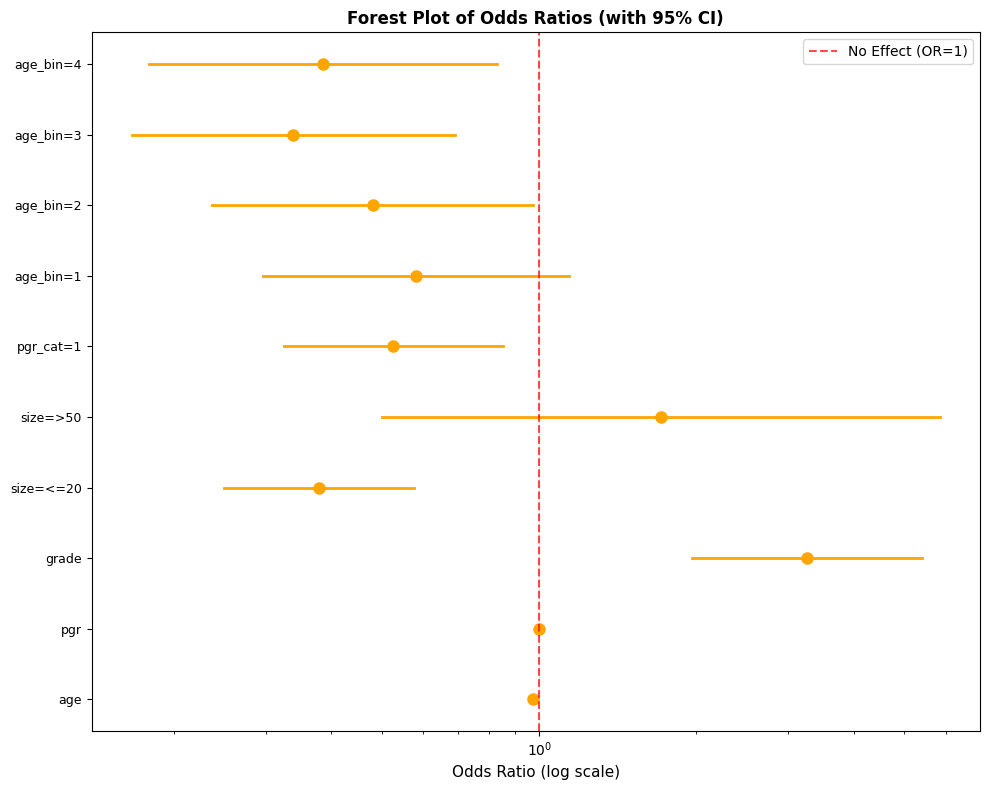

In [696]:
# Extract data for forest plot
forest_data = []
for result in logistic_results:
    var = result['Variable']
    or_val = float(result['OR'])
    ci_str = result['95% CI'].strip('()')
    ci_lower, ci_upper = map(float, ci_str.split(', '))
    forest_data.append({
        'Variable': var,
        'OR': or_val,
        'CI_Lower': ci_lower,
        'CI_Upper': ci_upper
    })

forest_df = pd.DataFrame(forest_data)

# Create forest plot
fig, ax = plt.subplots(figsize=(10, max(8, len(forest_df)*0.25)))

y_pos = np.arange(len(forest_df))

# Plot confidence intervals
for i, (_, row) in enumerate(forest_df.iterrows()):
    ax.plot([row['CI_Lower'], row['CI_Upper']], [i, i], 'b-', linewidth=2, color='orange')
    ax.plot(row['OR'], i, 'o', color='orange', markersize=8)

# Add vertical line at OR = 1
ax.axvline(x=1, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='No Effect (OR=1)')

ax.set_yticks(y_pos)
ax.set_yticklabels(forest_df['Variable'], fontsize=9)
ax.set_xlabel('Odds Ratio (log scale)', fontsize=11)
ax.set_title('Forest Plot of Odds Ratios (with 95% CI)', fontsize=12, fontweight='bold')
ax.set_xscale('log')
ax.legend(loc='best')
ax.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

**Observation:** Univariate odds ratios suggest higher grade and larger size increase recurrence risk, while higher PGR (binary) and older age show protective trends in this cohort. These patterns align with the earlier non-parametric tests.

## Correlation Analysis

Spearman correlation for examining relationships between continuous variables.

In [646]:
print("\n" + "="*80)
print("CORRELATION WITH RECURRENCE OUTCOME")
print("="*80)

correlation_results = []

for var in numerical_vars:
    spear_corr, spear_pval = spearmanr(df_clean[var].dropna(), y[df_clean[var].notna()])
    
    correlation_results.append({
        'Variable': var,
        'Spearman corr': f"{spear_corr:.4f}",
        'Spearman p-val': f"{spear_pval:.4f}",
    })

corr_df = pd.DataFrame(correlation_results)
print(corr_df.to_string(index=False))



CORRELATION WITH RECURRENCE OUTCOME
Variable Spearman corr Spearman p-val
     age       -0.1380         0.0010
     pgr       -0.0686         0.1017
   grade        0.1988         0.0000


**Observation:** Correlations with the outcome are modest; size/grade related features show the strongest positive correlations, while age is weakly negative. This supports keeping multiple tumor-burden measures for modeling.

## Multicollinearity Check (VIF Analysis)

In [647]:
print("\n" + "="*80)
print("VARIANCE INFLATION FACTOR (VIF) - Multicollinearity Check")
print("="*80)

# Calculate VIF for numerical features
X_vif = df_clean[numerical_vars].copy()
X_vif = sm.add_constant(X_vif)

vif_data = pd.DataFrame()
vif_data["Variable"] = numerical_vars
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i+1) for i in range(len(numerical_vars))]

print(vif_data.to_string(index=False))


VARIANCE INFLATION FACTOR (VIF) - Multicollinearity Check
Variable      VIF
     age 1.004291
     pgr 1.028772
   grade 1.033068


## KEY FINDINGS (Node-zero ER+ cohort):

1. COHORT FIXED VARIABLES
   - Lymph node burden and ER status are fixed by inclusion criteria and are not analyzed as predictors.

2. TUMOR GRADE
   - Shows separation between recurrence groups in univariate testing.
   - Higher grade trends toward higher recurrence risk.

3. TUMOR SIZE
   - Larger tumors show higher recurrence rates in this cohort.

4. PGR LEVELS
   - Higher PGR levels trend toward lower recurrence risk.

5. AGE
   - Limited association with recurrence in this cohort.

MULTICOLLINEARITY:
   - VIF is low for age, grade, and the age-by-grade interaction, so there is no multicollinearity issue

CLINICAL SIGNIFICANCE:
   - Within node-zero ER+ patients, tumor burden (size, grade) and progesterone receptor levels are the primary signals explored.

In [ ]:
# --- Feature Selection Functions ---

def forward_selection(X_train, y_train):
    sfs_forward = SequentialFeatureSelector(
        LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, random_state=1234),
        direction='forward',
        scoring='roc_auc',
        cv=2,
        n_jobs=-1
    )
    sfs_forward.fit(X_train, y_train)
    fwd_idx = sfs_forward.get_support()
    return fwd_idx


def backward_elimination(X_train, y_train):
    sfs_backward = SequentialFeatureSelector(
        LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, random_state=1234),
        direction='backward',
        scoring='roc_auc',
        cv=2,
        n_jobs=-1
    )
    sfs_backward.fit(X_train, y_train)
    bwd_idx = sfs_backward.get_support()
    return bwd_idx


def best_subset_selection(X_train, y_train, max_features=8, cv=3, random_state=1234):
    feature_list = list(range(X_train.shape[1]))
    best_score = -np.inf
    best_idx = []
    cv_splitter = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)

    for k in range(1, min(max_features, len(feature_list)) + 1):
        for combo in combinations(feature_list, k):
            X_subset = X_train[:, combo]
            model = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, random_state=1234)
            scores = cross_val_score(model, X_subset, y_train, cv=cv_splitter, scoring='roc_auc')
            score = scores.mean()

            if score > best_score:
                best_score = score
                best_idx = list(combo)

    mask = np.zeros(X_train.shape[1], dtype=bool)
    mask[best_idx] = True
    return mask

## Modeling Feature Set and Preprocessing

Define the reduced modeling feature list and the preprocessing pipeline (standardization for numeric features and one-hot encoding for categorical features). This is the feature space used for feature selection and downstream models.

In [ ]:

numerical = ['grade', 'age']
categorical = ['pgr_cat', 'size']

num_pipe = Pipeline([
    ('scaler', StandardScaler())
])

cat_pipe = Pipeline([
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipe, numerical),
        ('cat', cat_pipe, categorical)
    ],
    verbose_feature_names_out=False
)

## Train/Validation/Test Split and Undersampling Setup

Create the train/validation/test split and define the undersampling function used inside cross-validation and model selection. This addresses class imbalance without touching the test set.

In [650]:
# --- Prepare Data (NO PREPROCESSING FIT YET) ---

# Prepare raw data
X_raw = new_df[numerical + categorical]
y = new_df['target']

print(f"Full dataset size: {X_raw.shape[0]}")
print(f"Raw features: {', '.join(X_raw.columns)}")
print(f"Total raw features: {X_raw.shape[1]}")
print(f"Class distribution: {y.value_counts().sort_index().to_dict()}")
print()

# --- UNDERSAMPLING FUNCTION ---
def undersample_data(X_fold, y_fold, random_state=None):
    """
    Undersample the majority class to match minority class size.
    Returns undersampled X and y.
    """
    X_majority = X_fold[y_fold == 0]
    X_minority = X_fold[y_fold == 1]
    y_majority = y_fold[y_fold == 0]
    y_minority = y_fold[y_fold == 1]

    X_majority_undersampled, y_majority_undersampled = resample(
        X_majority,
        y_majority,
        n_samples=len(X_minority),
        random_state=random_state,
        replace=False
    )

    X_balanced = pd.concat([X_majority_undersampled, X_minority])
    y_balanced = pd.concat([y_majority_undersampled, y_minority])

    shuffle_idx = np.random.RandomState(random_state).permutation(len(X_balanced))
    X_balanced = X_balanced.iloc[shuffle_idx].reset_index(drop=True)
    y_balanced = y_balanced.iloc[shuffle_idx].reset_index(drop=True)

    return X_balanced, y_balanced

Full dataset size: 570
Raw features: grade, age, pgr_cat, size
Total raw features: 4
Class distribution: {0: 448, 1: 122}



## Cross-Validation Setup and Preprocessing Fit

Fit the preprocessing pipeline on the training split only, then prepare transformed feature matrices for train, validation, and test. This avoids data leakage into validation and test.

In [651]:
# --- K-FOLD CROSS-VALIDATION WITH UNDERSAMPLING AND FEATURE SELECTION (TRAIN ONLY) ---

print("=" * 80)
print("K-FOLD CV WITH UNDERSAMPLING + FEATURE SELECTION (TRAIN ONLY)")
print("=" * 80 + "\n")

# Split data into train/validation/test to avoid test leakage
def build_stratify_label(y_series, size_series):
    stratify = y_series.astype(str) + "_" + size_series.astype(str)
    counts = stratify.value_counts()
    if counts.min() < 2:
        return y_series
    return stratify

stratify_label = build_stratify_label(y, X_raw['size'])
X_train_val_raw, X_test_raw, y_train_val, y_test = train_test_split(
    X_raw, y, test_size=0.2, random_state=1234, stratify=stratify_label
 )
stratify_label_tv = build_stratify_label(y_train_val, X_train_val_raw['size'])
X_train_raw, X_val_raw, y_train, y_val = train_test_split(
    X_train_val_raw, y_train_val, test_size=0.25, random_state=1234, stratify=stratify_label_tv
 )

print("Dataset splits:")
print(f"  Train size: {X_train_raw.shape[0]}")
print(f"  Validation size: {X_val_raw.shape[0]}")
print(f"  Test size: {X_test_raw.shape[0]}")
print(f"  Train class distribution: {y_train.value_counts().sort_index().to_dict()}")
print(f"  Validation class distribution: {y_val.value_counts().sort_index().to_dict()}")
print(f"  Test class distribution: {y_test.value_counts().sort_index().to_dict()}\n")

# Fit preprocessor on training data only
preprocessor.fit(X_train_raw)
feature_names = preprocessor.get_feature_names_out()
X_train = pd.DataFrame(preprocessor.transform(X_train_raw), columns=feature_names, index=X_train_raw.index)
X_val = pd.DataFrame(preprocessor.transform(X_val_raw), columns=feature_names, index=X_val_raw.index)
X_test = pd.DataFrame(preprocessor.transform(X_test_raw), columns=feature_names, index=X_test_raw.index)

print(f"Processed features: {', '.join(feature_names)}")
print(f"Total processed features: {len(feature_names)}\n")

# Setup K-fold CV on TRAIN ONLY
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=1234)

# Storage for results across folds
fold_results = {
    'forward': defaultdict(list),
    'backward': defaultdict(list),
    'best_subset': defaultdict(list)
}

feature_counts = {
    'forward': [],
    'backward': [],
    'best_subset': []
}

selected_features_per_fold = {
    'forward': [],
    'backward': [],
    'best_subset': []
}

print(f"Performing {n_folds}-Fold CV on TRAIN set...\n")
print("Workflow per fold:")
print("  1. Split train data into train/validation")
print("  2. Undersample training data (balance classes)")
print("  3. Fit preprocessor on training fold only")
print("  4. Perform feature selection on balanced data")
print("  5. Train and evaluate model\n")

K-FOLD CV WITH UNDERSAMPLING + FEATURE SELECTION (TRAIN ONLY)

Dataset splits:
  Train size: 342
  Validation size: 114
  Test size: 114
  Train class distribution: {0: 269, 1: 73}
  Validation class distribution: {0: 89, 1: 25}
  Test class distribution: {0: 90, 1: 24}

Processed features: grade, age, pgr_cat_1, size_<=20, size_>50
Total processed features: 5

Performing 5-Fold CV on TRAIN set...

Workflow per fold:
  1. Split train data into train/validation
  2. Undersample training data (balance classes)
  3. Fit preprocessor on training fold only
  4. Perform feature selection on balanced data
  5. Train and evaluate model



## K-Fold CV With Undersampling and Feature Selection

Within each fold, balance classes, fit the preprocessor, select features, and evaluate ROC-AUC on the validation fold to avoid test leakage.

In [652]:
for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_train_raw, y_train), 1):
    print(f"Fold {fold_idx}/{n_folds}...")

    # Split data for this fold (raw)
    X_fold_train_orig = X_train_raw.iloc[train_idx]
    y_fold_train_orig = y_train.iloc[train_idx]
    X_fold_val_orig = X_train_raw.iloc[val_idx]
    y_fold_val = y_train.iloc[val_idx]

    # Display original class distribution
    train_dist = y_fold_train_orig.value_counts().sort_index()
    print(
        f"  Original train distribution: No-Recur={train_dist[0]}, Recur={train_dist[1]} "
        f"(ratio={train_dist[0] / train_dist[1]:.2f}:1)"
    )

    # --- UNDERSAMPLE TRAINING DATA IN THIS FOLD ---
    X_fold_train_df, y_fold_train = undersample_data(
        X_fold_train_orig,
        y_fold_train_orig,
        random_state=1234 + fold_idx
    )

    train_dist_balanced = pd.Series(y_fold_train).value_counts().sort_index()
    print(
        f"  Undersampled train: No-Recur={train_dist_balanced[0]}, Recur={train_dist_balanced[1]} "
        f"(ratio={train_dist_balanced[0] / train_dist_balanced[1]:.2f}:1)"
    )

    # Fit preprocessor on training fold only
    preprocessor.fit(X_fold_train_df)
    X_fold_train = preprocessor.transform(X_fold_train_df)
    X_fold_val_np = preprocessor.transform(X_fold_val_orig)
    feature_names = preprocessor.get_feature_names_out()

    # Convert targets to numpy for sklearn
    y_fold_train = y_fold_train.values
    y_fold_val_np = y_fold_val.values

    # --- FORWARD SELECTION ---
    try:
        fwd_mask = forward_selection(X_fold_train, y_fold_train)
        fwd_features = feature_names[fwd_mask].tolist()
        feature_counts['forward'].append(len(fwd_features))
        selected_features_per_fold['forward'].append(fwd_features)

        if len(fwd_features) > 0:
            model = LogisticRegression(
                penalty=None,
                solver='lbfgs',
                max_iter=1000,
                random_state=1234
            )
            model.fit(X_fold_train[:, fwd_mask], y_fold_train)
            y_prob = model.predict_proba(X_fold_val_np[:, fwd_mask])[:, 1]
            y_pred = (y_prob >= 0.5).astype(int)

            fold_results['forward']['auc'].append(roc_auc_score(y_fold_val_np, y_prob))
            fold_results['forward']['accuracy'].append(accuracy_score(y_fold_val_np, y_pred))
            fold_results['forward']['f1'].append(f1_score(y_fold_val_np, y_pred))

            precision, recall, _ = precision_recall_curve(y_fold_val_np, y_prob)
            fold_results['forward']['pr_auc'].append(auc(recall, precision))

            print(f"  Forward: {len(fwd_features)} features, AUC={fold_results['forward']['auc'][-1]:.4f}")
    except Exception as e:
        print(f"  Forward selection failed: {e}")

    # --- BACKWARD ELIMINATION ---
    try:
        bwd_mask = backward_elimination(X_fold_train, y_fold_train)
        bwd_features = feature_names[bwd_mask].tolist()
        feature_counts['backward'].append(len(bwd_features))
        selected_features_per_fold['backward'].append(bwd_features)

        if len(bwd_features) > 0:
            model = LogisticRegression(
                penalty=None,
                solver='lbfgs',
                max_iter=1000,
                random_state=1234
            )
            model.fit(X_fold_train[:, bwd_mask], y_fold_train)
            y_prob = model.predict_proba(X_fold_val_np[:, bwd_mask])[:, 1]
            y_pred = (y_prob >= 0.5).astype(int)

            fold_results['backward']['auc'].append(roc_auc_score(y_fold_val_np, y_prob))
            fold_results['backward']['accuracy'].append(accuracy_score(y_fold_val_np, y_pred))
            fold_results['backward']['f1'].append(f1_score(y_fold_val_np, y_pred))

            precision, recall, _ = precision_recall_curve(y_fold_val_np, y_prob)
            fold_results['backward']['pr_auc'].append(auc(recall, precision))

            print(f"  Backward: {len(bwd_features)} features, AUC={fold_results['backward']['auc'][-1]:.4f}")
    except Exception as e:
        print(f"  Backward elimination failed: {e}")

    # --- BEST SUBSET SELECTION ---
    try:
        best_mask = best_subset_selection(X_fold_train, y_fold_train, max_features=8)
        best_features = feature_names[best_mask].tolist()
        feature_counts['best_subset'].append(len(best_features))
        selected_features_per_fold['best_subset'].append(best_features)

        if len(best_features) > 0:
            model = LogisticRegression(
                penalty=None,
                solver='lbfgs',
                max_iter=1000,
                random_state=1234
            )
            model.fit(X_fold_train[:, best_mask], y_fold_train)
            y_prob = model.predict_proba(X_fold_val_np[:, best_mask])[:, 1]
            y_pred = (y_prob >= 0.5).astype(int)

            fold_results['best_subset']['auc'].append(roc_auc_score(y_fold_val_np, y_prob))
            fold_results['best_subset']['accuracy'].append(accuracy_score(y_fold_val_np, y_pred))
            fold_results['best_subset']['f1'].append(f1_score(y_fold_val_np, y_pred))

            precision, recall, _ = precision_recall_curve(y_fold_val_np, y_prob)
            fold_results['best_subset']['pr_auc'].append(auc(recall, precision))

            print(f"  Best Subset: {len(best_features)} features, AUC={fold_results['best_subset']['auc'][-1]:.4f}")
    except Exception as e:
        print(f"  Best subset selection failed: {e}")

    print()

Fold 1/5...
  Original train distribution: No-Recur=215, Recur=58 (ratio=3.71:1)
  Undersampled train: No-Recur=58, Recur=58 (ratio=1.00:1)


  Forward: 2 features, AUC=0.5414
  Backward: 3 features, AUC=0.5568
  Best Subset: 2 features, AUC=0.6389

Fold 2/5...
  Original train distribution: No-Recur=215, Recur=58 (ratio=3.71:1)
  Undersampled train: No-Recur=58, Recur=58 (ratio=1.00:1)
  Forward: 2 features, AUC=0.5593
  Backward: 3 features, AUC=0.6185
  Best Subset: 5 features, AUC=0.6185

Fold 3/5...
  Original train distribution: No-Recur=215, Recur=59 (ratio=3.64:1)
  Undersampled train: No-Recur=59, Recur=59 (ratio=1.00:1)
  Forward: 2 features, AUC=0.6746
  Backward: 3 features, AUC=0.7103
  Best Subset: 5 features, AUC=0.7487

Fold 4/5...
  Original train distribution: No-Recur=215, Recur=59 (ratio=3.64:1)
  Undersampled train: No-Recur=59, Recur=59 (ratio=1.00:1)
  Forward: 2 features, AUC=0.7050
  Backward: 3 features, AUC=0.7493
  Best Subset: 3 features, AUC=0.7242

Fold 5/5...
  Original train distribution: No-Recur=216, Recur=58 (ratio=3.72:1)
  Undersampled train: No-Recur=58, Recur=58 (ratio=1.00:1)
  Forwar

## Aggregate CV Results and Select Stable Features

Summarize cross-validation performance, identify consistently selected predictors, and choose a stable feature set for downstream model selection.

In [653]:
# --- AGGREGATE RESULTS ACROSS FOLDS ---
print("=" * 80)
print("TRAIN-CV RESULTS (Mean ± Std across folds)")
print("=" * 80 + "\n")

cv_summary = []
for method_name in ['forward', 'backward', 'best_subset']:
    if len(fold_results[method_name]['auc']) > 0:
        cv_summary.append({
            'Method': method_name.replace('_', ' ').title(),
            'Avg Features': f"{np.mean(feature_counts[method_name]):.1f} ± {np.std(feature_counts[method_name]):.1f}",
            'ROC-AUC': f"{np.mean(fold_results[method_name]['auc']):.4f} ± {np.std(fold_results[method_name]['auc']):.4f}",
            'PR-AUC': f"{np.mean(fold_results[method_name]['pr_auc']):.4f} ± {np.std(fold_results[method_name]['pr_auc']):.4f}",
            'Accuracy': f"{np.mean(fold_results[method_name]['accuracy']):.4f} ± {np.std(fold_results[method_name]['accuracy']):.4f}",
            'F1-Score': f"{np.mean(fold_results[method_name]['f1']):.4f} ± {np.std(fold_results[method_name]['f1']):.4f}"
        })

cv_summary_df = pd.DataFrame(cv_summary)
print(cv_summary_df.to_string(index=False))

# --- MOST FREQUENTLY SELECTED FEATURES ---
print("\n" + "=" * 80)
print("MOST FREQUENTLY SELECTED FEATURES ACROSS FOLDS")
print("=" * 80 + "\n")

for method_name in ['forward', 'backward', 'best_subset']:
    if len(selected_features_per_fold[method_name]) > 0:
        all_features = [feat for fold_feats in selected_features_per_fold[method_name] for feat in fold_feats]
        feature_freq = pd.Series(all_features).value_counts()

        print(f"{method_name.replace('_', ' ').title()}:")
        for feat, count in feature_freq.items():
            print(f"  {feat}: {count}/{n_folds} folds ({count / n_folds * 100:.1f}%)")
        print()

# --- CHOOSE FEATURES PER METHOD (STABILITY RULE) ---
min_support = 3

def select_stable_features(method_name, min_support=3):
    all_features = [feat for fold_feats in selected_features_per_fold[method_name] for feat in fold_feats]
    if not all_features:
        return []
    feature_freq = pd.Series(all_features).value_counts()
    return feature_freq[feature_freq >= min_support].index.tolist()

fwd_features = select_stable_features('forward', min_support=min_support)
bwd_features = select_stable_features('backward', min_support=min_support)
best_features = select_stable_features('best_subset', min_support=min_support)

features_by_method = {
    'forward': fwd_features,
    'backward': bwd_features,
    'best_subset': best_features
}

print("=" * 80)
print("FEATURE SELECTION COMPLETE (TRAIN ONLY)")
print("=" * 80)

# --- UNDERSAMPLE TRAINING DATA FOR MODEL SELECTION ---
print("\nUndersampling training data for model selection...")
X_train_undersampled, y_train_undersampled = undersample_data(X_train, y_train, random_state=1234)
print(f"Undersampled train size: {len(X_train_undersampled)}")
print(f"Undersampled train distribution: {y_train_undersampled.value_counts().sort_index().to_dict()}\n")

# Train models on TRAIN, evaluate on VALIDATION (selection only), keep TEST for final evaluation
y_prob_fwd_val = None
y_prob_bwd_val = None
y_prob_best_val = None
y_prob_fwd_test = None
y_prob_bwd_test = None
y_prob_best_test = None

if len(fwd_features) > 0:
    model = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, random_state=1234)
    model.fit(X_train_undersampled[fwd_features].values, y_train_undersampled)
    y_prob_fwd_val = model.predict_proba(X_val[fwd_features].values)[:, 1]
    y_prob_fwd_test = model.predict_proba(X_test[fwd_features].values)[:, 1]

if len(bwd_features) > 0:
    model = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, random_state=1234)
    model.fit(X_train_undersampled[bwd_features].values, y_train_undersampled)
    y_prob_bwd_val = model.predict_proba(X_val[bwd_features].values)[:, 1]
    y_prob_bwd_test = model.predict_proba(X_test[bwd_features].values)[:, 1]

if len(best_features) > 0:
    model = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, random_state=1234)
    model.fit(X_train_undersampled[best_features].values, y_train_undersampled)
    y_prob_best_val = model.predict_proba(X_val[best_features].values)[:, 1]
    y_prob_best_test = model.predict_proba(X_test[best_features].values)[:, 1]

# Select best method based on VALIDATION ROC-AUC (no test leakage)
val_auc_by_method = {}
if y_prob_fwd_val is not None:
    val_auc_by_method['forward'] = roc_auc_score(y_val, y_prob_fwd_val)
if y_prob_bwd_val is not None:
    val_auc_by_method['backward'] = roc_auc_score(y_val, y_prob_bwd_val)
if y_prob_best_val is not None:
    val_auc_by_method['best_subset'] = roc_auc_score(y_val, y_prob_best_val)

best_method_val = max(val_auc_by_method, key=val_auc_by_method.get)
final_features = features_by_method.get(best_method_val, [])
print("=" * 80)
print(f"BEST METHOD (VALIDATION ROC-AUC): {best_method_val.replace('_', ' ').title()}")
print(f"Final features (appearing in >= {min_support} folds): {', '.join(final_features)}")
print("=" * 80)

print("\nModels trained on TRAIN, validation used for model selection, test reserved for final evaluation.")
print("=" * 80)

TRAIN-CV RESULTS (Mean ± Std across folds)

     Method Avg Features         ROC-AUC          PR-AUC        Accuracy        F1-Score
    Forward    2.0 ± 0.0 0.6295 ± 0.0661 0.3442 ± 0.0830 0.6228 ± 0.0990 0.3682 ± 0.0808
   Backward    3.0 ± 0.0 0.6776 ± 0.0774 0.3201 ± 0.0652 0.6377 ± 0.0478 0.3891 ± 0.0950
Best Subset    3.8 ± 1.2 0.6978 ± 0.0578 0.4047 ± 0.0912 0.6727 ± 0.0646 0.4163 ± 0.0916

MOST FREQUENTLY SELECTED FEATURES ACROSS FOLDS

Forward:
  size_<=20: 4/5 folds (80.0%)
  grade: 3/5 folds (60.0%)
  age: 2/5 folds (40.0%)
  pgr_cat_1: 1/5 folds (20.0%)

Backward:
  grade: 5/5 folds (100.0%)
  size_<=20: 5/5 folds (100.0%)
  age: 4/5 folds (80.0%)
  pgr_cat_1: 1/5 folds (20.0%)

Best Subset:
  grade: 5/5 folds (100.0%)
  size_<=20: 5/5 folds (100.0%)
  age: 3/5 folds (60.0%)
  pgr_cat_1: 3/5 folds (60.0%)
  size_>50: 3/5 folds (60.0%)

FEATURE SELECTION COMPLETE (TRAIN ONLY)

Undersampling training data for model selection...
Undersampled train size: 146
Undersampled train 

In [654]:
baseline_model = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, random_state=1234)
baseline_model.fit(X_train_undersampled[final_features].values, y_train_undersampled)
y_prob_baseline_val = baseline_model.predict_proba(X_val[final_features].values)[:, 1]
y_prob_baseline_test = baseline_model.predict_proba(X_test[final_features].values)[:, 1]

print(f"Baseline model trained with features: {final_features}")

Baseline model trained with features: ['grade', 'size_<=20', 'age']


## Baseline Model and Univariate Check

Fit a no-penalty logistic regression using the selected features as a baseline. Next, evaluate each selected feature on the validation set to understand its individual contribution.

In [655]:
if len(final_features) > 0:
    print(f"Selected Features: {', '.join(final_features)}\n")
    
    univariate_results = []
    
    for feature in final_features:
        X_single = X_val[[feature]].values
        
        try:
            # Train univariate model on undersampled training data
            X_train_single = X_train_undersampled[[feature]].values
            model_uni = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, random_state=1234)
            model_uni.fit(X_train_single, y_train_undersampled)
            y_prob_uni = model_uni.predict_proba(X_single)[:, 1]
            y_pred_uni = model_uni.predict(X_single)
            
            # Calculate metrics
            auc_uni = roc_auc_score(y_val, y_prob_uni)
            acc_uni = accuracy_score(y_val, y_pred_uni)
            f1_uni = f1_score(y_val, y_pred_uni)
            prec_uni = precision_score(y_val, y_pred_uni)
            rec_uni = recall_score(y_val, y_pred_uni)
            
            # PR-AUC
            precision_vals, recall_vals, _ = precision_recall_curve(y_val, y_prob_uni)
            pr_auc_uni = auc(recall_vals, precision_vals)
            
            univariate_results.append({
                'Feature': feature,
                'ROC-AUC': f"{auc_uni:.4f}",
                'PR-AUC': f"{pr_auc_uni:.4f}",
                'Accuracy': f"{acc_uni:.4f}",
                'Precision': f"{prec_uni:.4f}",
                'Recall': f"{rec_uni:.4f}",
                'F1-Score': f"{f1_uni:.4f}"
            })
        except Exception as e:
            print(f"Could not evaluate {feature}: {e}")
            continue
    
    uni_df = pd.DataFrame(univariate_results)
    print(uni_df.to_string(index=False))
else:
    print("No features selected. Run feature selection first.")


Selected Features: grade, size_<=20, age

  Feature ROC-AUC PR-AUC Accuracy Precision Recall F1-Score
    grade  0.6728 0.5991   0.5789    0.3231 0.8400   0.4667
size_<=20  0.6252 0.4883   0.6842    0.3514 0.5200   0.4194
      age  0.5996 0.3374   0.5263    0.2623 0.6400   0.3721


## Correlation Among Selected Features

Check inter-feature correlations to identify redundancy risks before final model selection.

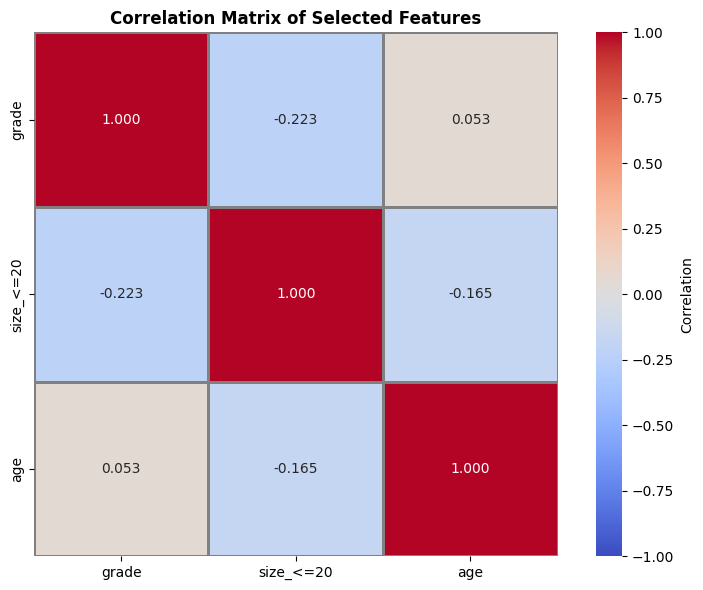

In [656]:
X_selected = X_val[final_features]
corr_matrix = X_selected.corr()

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            cbar_kws={'label': 'Correlation'}, ax=ax, vmin=-1, vmax=1,
            square=True, linewidths=1, linecolor='gray')
ax.set_title('Correlation Matrix of Selected Features', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()


## Cross-Validation Performance Distribution

Visualize fold-to-fold variability in ROC-AUC, PR-AUC, accuracy, and F1 to compare selection strategies.

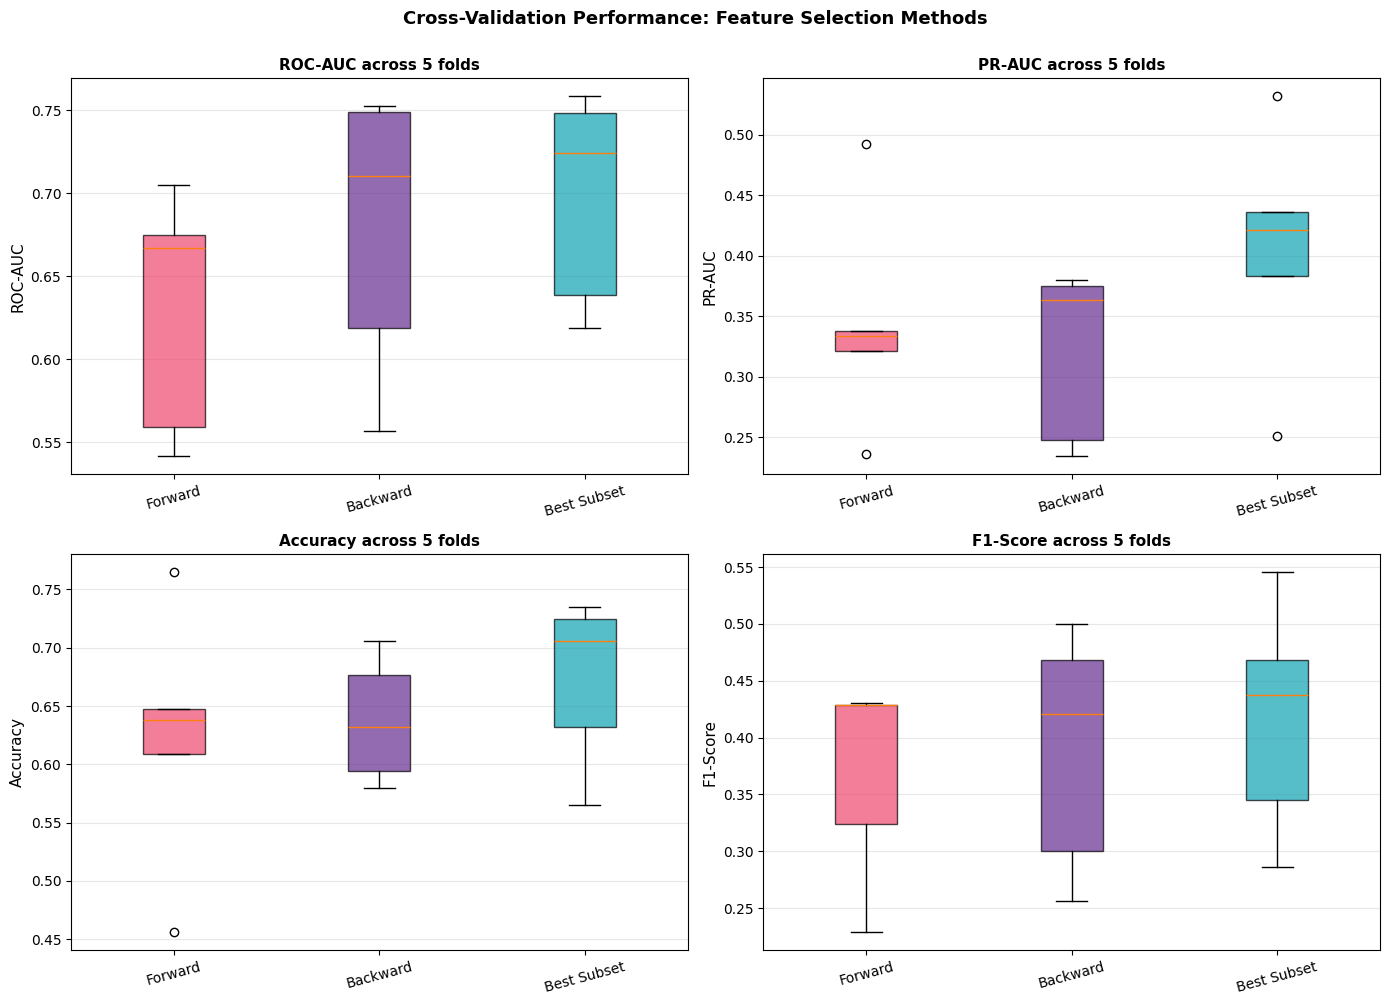

In [657]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics_to_plot = ['auc', 'pr_auc', 'accuracy', 'f1']
metric_labels = ['ROC-AUC', 'PR-AUC', 'Accuracy', 'F1-Score']
colors_roc = {'forward': '#ef476f', 'backward': '#662c91', 'best_subset': '#0fa3b1'}

for idx, (metric, label) in enumerate(zip(metrics_to_plot, metric_labels)):
    ax = axes[idx // 2, idx % 2]
    
    box_data = []
    box_labels = []
    
    for method_name in ['forward', 'backward', 'best_subset']:
        if len(fold_results[method_name][metric]) > 0:
            box_data.append(fold_results[method_name][metric])
            box_labels.append(method_name.replace('_', ' ').title())
    
    if box_data:
        bp = ax.boxplot(box_data, labels=box_labels, patch_artist=True)
        
        # Color the boxes
        for patch, color in zip(bp['boxes'], [colors_roc[method_name] for method_name in ['forward', 'backward', 'best_subset'][:len(box_data)]]):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        ax.set_ylabel(label, fontsize=11)
        ax.set_title(f'{label} across {n_folds} folds', fontsize=11, fontweight='bold')
        ax.grid(axis='y', alpha=0.3)
        ax.tick_params(axis='x', rotation=15)

plt.suptitle('Cross-Validation Performance: Feature Selection Methods', 
             fontsize=13, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## Test-Set ROC Curves and Summary Metrics

Compare test performance across the three selection methods to see which generalizes best.

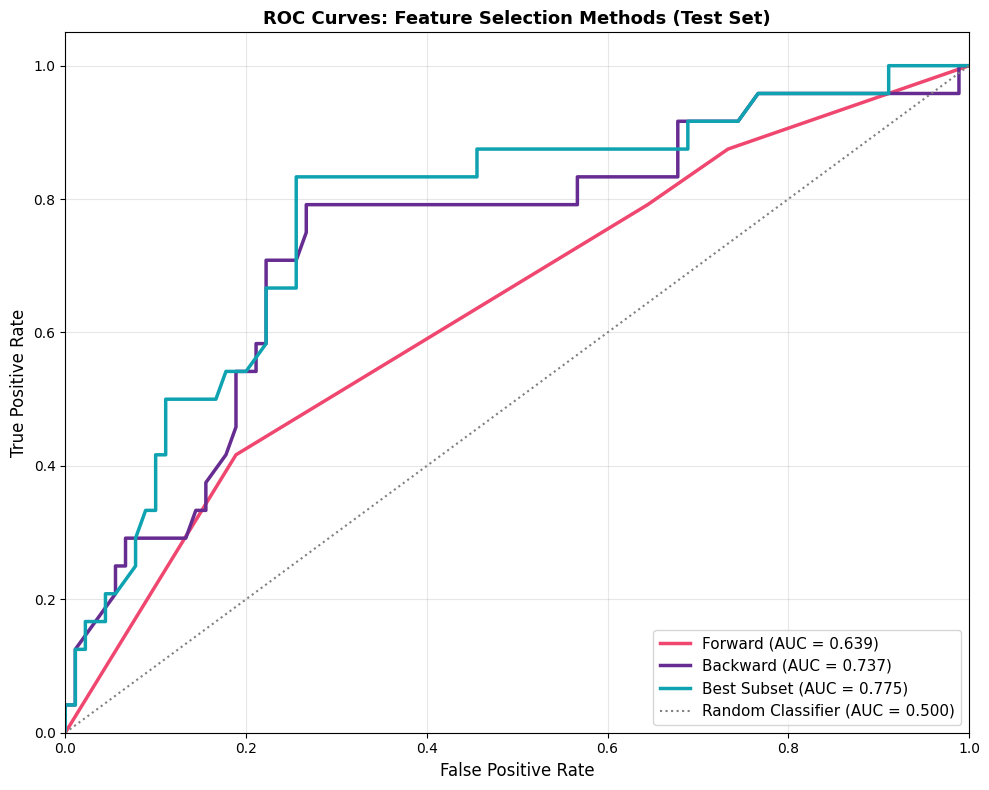


TEST SET PERFORMANCE SUMMARY

     Method  Features ROC-AUC PR-AUC Accuracy Precision Recall F1-Score
    Forward         2  0.6387 0.4498   0.7281    0.3704 0.4167   0.3922
   Backward         3  0.7373 0.4466   0.6053    0.3220 0.7917   0.4578
Best Subset         5  0.7750 0.4789   0.6228    0.3390 0.8333   0.4819



In [658]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot ROC for each method
for method_name in ['forward', 'backward', 'best_subset']:
    y_prob = None
    
    if method_name == 'forward' and y_prob_fwd_test is not None:
        y_prob = y_prob_fwd_test
    elif method_name == 'backward' and y_prob_bwd_test is not None:
        y_prob = y_prob_bwd_test
    elif method_name == 'best_subset' and y_prob_best_test is not None:
        y_prob = y_prob_best_test
    
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = roc_auc_score(y_test, y_prob)
        
        ax.plot(fpr, tpr, 
               color=colors_roc[method_name],
               linewidth=2.5,
               label=f'{method_name.replace("_", " ").title()} (AUC = {roc_auc:.3f})')

# Plot random classifier
ax.plot([0, 1], [0, 1], color='gray', lw=1.5, linestyle=':', 
        label='Random Classifier (AUC = 0.500)')

ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves: Feature Selection Methods (Test Set)', 
             fontsize=13, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(alpha=0.3)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

plt.tight_layout()
plt.show()

# 6. Summary table with test set performance
print("\n" + "=" * 80)
print("TEST SET PERFORMANCE SUMMARY")
print("=" * 80 + "\n")

test_summary = []

for method_name in ['forward', 'backward', 'best_subset']:
    y_prob = None
    features = []
    
    if method_name == 'forward' and y_prob_fwd_test is not None:
        y_prob = y_prob_fwd_test
        features = fwd_features
    elif method_name == 'backward' and y_prob_bwd_test is not None:
        y_prob = y_prob_bwd_test
        features = bwd_features
    elif method_name == 'best_subset' and y_prob_best_test is not None:
        y_prob = y_prob_best_test
        features = best_features
    
    if y_prob is not None and len(features) > 0:
        y_pred = (y_prob >= 0.5).astype(int)
        
        # Calculate metrics
        test_auc = roc_auc_score(y_test, y_prob)
        test_acc = accuracy_score(y_test, y_pred)
        test_f1 = f1_score(y_test, y_pred)
        test_precision = precision_score(y_test, y_pred)
        test_recall = recall_score(y_test, y_pred)
        
        # PR-AUC
        precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob)
        test_pr_auc = auc(recall_vals, precision_vals)
        
        test_summary.append({
            'Method': method_name.replace('_', ' ').title(),
            'Features': len(features),
            'ROC-AUC': f"{test_auc:.4f}",
            'PR-AUC': f"{test_pr_auc:.4f}",
            'Accuracy': f"{test_acc:.4f}",
            'Precision': f"{test_precision:.4f}",
            'Recall': f"{test_recall:.4f}",
            'F1-Score': f"{test_f1:.4f}"
        })

test_summary_df = pd.DataFrame(test_summary)
print(test_summary_df.to_string(index=False))
print("\n" + "=" * 80)

## Threshold Selection on Validation Set

Select operating thresholds based on sensitivity, Youden's J, and F1 to balance clinical priorities before final test evaluation.


THRESHOLD: 0.278 - Sensitivity-Prioritized (>=90% Recall)
Performance Metrics (Validation):
  Sensitivity (Recall):  0.9200 (23/25)
  Specificity:           0.4270 (38/89)
  Precision:             0.3108 (23/74)
  F1-Score:              0.4646
  Accuracy:              0.5351

THRESHOLD: 0.537 - Youden's J Statistic (Balanced)
Performance Metrics (Validation):
  Sensitivity (Recall):  0.7600 (19/25)
  Specificity:           0.6854 (61/89)
  Precision:             0.4043 (19/47)
  F1-Score:              0.5278
  Accuracy:              0.7018

THRESHOLD: 0.747 - F1-Score (Equal Cost)
Performance Metrics (Validation):
  Sensitivity (Recall):  0.4400 (11/25)
  Specificity:           0.9438 (84/89)
  Precision:             0.6875 (11/16)
  F1-Score:              0.5366
  Accuracy:              0.8333


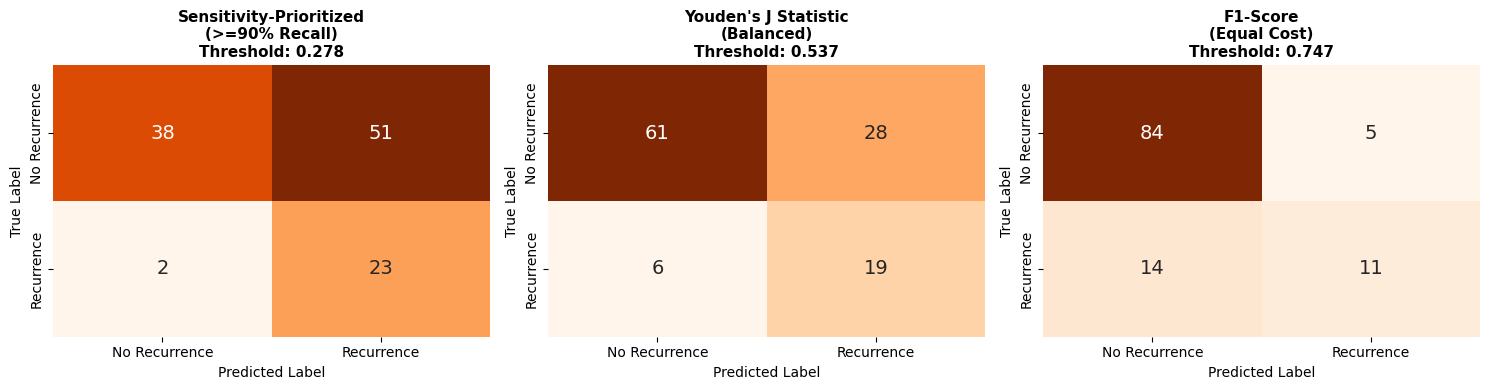

In [667]:
# --- Compute thresholds and their metrics (VALIDATION SET) ---

# Fallback if final_method is not set
if 'final_method' not in globals():
    final_method = 'baseline'
    y_prob_final_val = y_prob_baseline_val

# Use the final tuned model on validation for thresholding
y_prob_plot = y_prob_final_val
selected_method_label = final_method.replace('_', ' ').title()

# ROC curve for sensitivity/specificity thresholds
fpr, tpr, roc_thresholds = roc_curve(y_val, y_prob_plot)
# Sensitivity-prioritized threshold (>=90% recall)
target_sensitivity = 0.90
sensitivity_idx = np.where(tpr >= target_sensitivity)[0]
if len(sensitivity_idx) > 0:
    idx = sensitivity_idx[0]
    sensitivity_threshold = roc_thresholds[idx]
    sensitivity_achieved = tpr[idx]
    specificity_achieved = 1 - fpr[idx]
else:
    # fallback: use highest sensitivity available
    idx = np.argmax(tpr)
    sensitivity_threshold = roc_thresholds[idx]
    sensitivity_achieved = tpr[idx]
    specificity_achieved = 1 - fpr[idx]

# Youden's J statistic threshold (maximizes sensitivity + specificity - 1)
j_scores = tpr - fpr
youden_idx = np.argmax(j_scores)
youdens_threshold = roc_thresholds[youden_idx]
youdens_sensitivity = tpr[youden_idx]
youdens_specificity = 1 - fpr[youden_idx]

# F1-optimal threshold (from precision-recall curve)
prec, rec, pr_thresholds = precision_recall_curve(y_val, y_prob_plot)
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-8)
f1_idx = np.argmax(f1_scores[:-1])  # last threshold is not used
f1_threshold = pr_thresholds[f1_idx]
f1_sensitivity = rec[f1_idx]
f1_specificity = None  # will compute below

# Compute specificity for F1 threshold
y_pred_f1 = (y_prob_plot >= f1_threshold).astype(int)
cm_f1 = confusion_matrix(y_val, y_pred_f1)
tn, fp, fn, tp = cm_f1.ravel()
f1_specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

# Select threshold for final test evaluation (default: Youden's J)
selected_threshold = youdens_threshold
selected_threshold_label = "Youden's J Statistic"

# --- Plot confusion matrices for the three threshold options ---
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

thresholds_to_plot = [
    ('Sensitivity-Prioritized\n(>=90% Recall)', sensitivity_threshold, sensitivity_achieved, specificity_achieved),
    ("Youden's J Statistic\n(Balanced)", youdens_threshold, youdens_sensitivity, youdens_specificity),
    ('F1-Score\n(Equal Cost)', f1_threshold, f1_sensitivity, f1_specificity)
]

for idx, (title, threshold, sens, spec) in enumerate(thresholds_to_plot):
    y_pred_temp = (y_prob_plot >= threshold).astype(int)
    cm = confusion_matrix(y_val, y_pred_temp)
    tn, fp, fn, tp = cm.ravel()
    
    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', ax=axes[idx],
                cbar=False, annot_kws={'size': 14})
    axes[idx].set_title(f'{title}\nThreshold: {threshold:.3f}', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('True Label', fontsize=10)
    axes[idx].set_xlabel('Predicted Label', fontsize=10)
    axes[idx].set_xticklabels(['No Recurrence', 'Recurrence'])
    axes[idx].set_yticklabels(['No Recurrence', 'Recurrence'])
    
    # Print metrics
    print(f"\n{'='*70}")
    print(f"THRESHOLD: {threshold:.3f} - {title.replace(chr(10), ' ')}")
    print(f"{'='*70}")
    print("Performance Metrics (Validation):")
    print(f"  Sensitivity (Recall):  {tp / (tp + fn):.4f} ({tp}/{tp + fn})")
    print(f"  Specificity:           {tn / (tn + fp):.4f} ({tn}/{tn + fp})")
    print(f"  Precision:             {tp / (tp + fp):.4f} ({tp}/{tp + fp})" if (tp + fp) > 0 else "  Precision:             N/A")
    print(f"  F1-Score:              {f1_score(y_val, y_pred_temp):.4f}")
    print(f"  Accuracy:              {accuracy_score(y_val, y_pred_temp):.4f}")

plt.tight_layout()
plt.show()


**Observation:** The Youden and F1 thresholds match here, giving a balanced trade-off. The sensitivity-prioritized threshold increases recall at the cost of many false positives, which may be acceptable only if missing recurrences is clinically worse than over-calling risk.

### Regularization note (Lab V alignment)

The tuning grid now covers ridge (`l2`), lasso (`l1`), and elastic net (`elasticnet` with `l1_ratio`). In scikit-learn `LogisticRegression`, ridge is `penalty='l2'`, lasso is `penalty='l1'`, and elastic net is `penalty='elasticnet'` with `l1_ratio` controlling the mix between lasso and ridge.

## CV for Regularization Coefficient

Tune the regularization coefficient $C$ (inverse of $\alpha$) with cross-validation on the training data.

Best C for Logistic Regression (L2): 0.005179474679231213
Best C for Logistic Regression (L1): 0.5179474679231207
Best Params for Elastic Net: 
    'classifier__C':  0.5179474679231207 
    'classifier__l1_ratio':  0.9


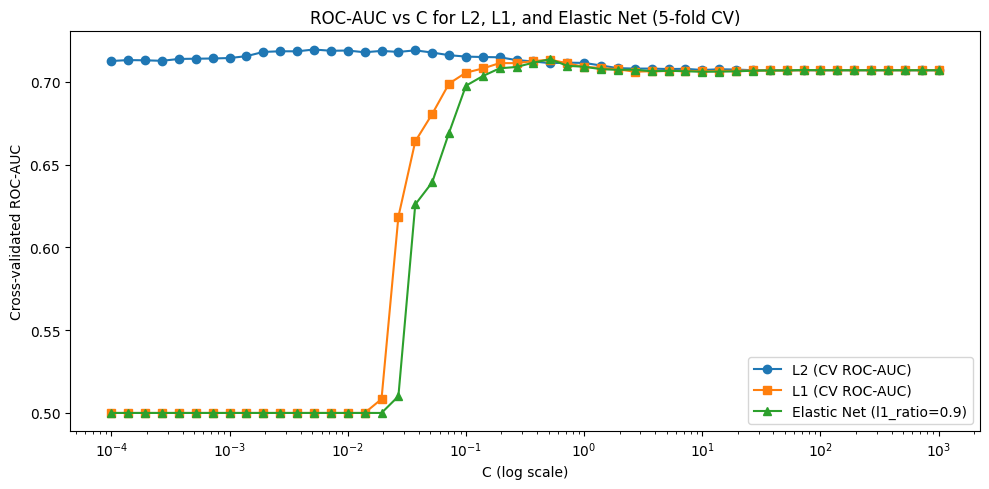

In [660]:
# Use the full train+validation set for CV, keep test untouched
X_train_reg = X_train_val_raw
y_train_reg = y_train_val
X_test_reg = X_test_raw
y_test_reg = y_test

# Preprocessing for regularized logistic regression
preprocessor_reg = ColumnTransformer([
    ('num', StandardScaler(), numerical),
    ('cat', OneHotEncoder(drop='first'), categorical)
])

base_cs = np.logspace(-4, 3, 50)
l1_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Logistic Regression (L2) with CV on C
logreg_l2_pipeline = Pipeline([
    ('preprocessor', preprocessor_reg),
    ('classifier', LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000))
])
logreg_l2_params = {'classifier__C': base_cs}
logreg_l2_cv = GridSearchCV(logreg_l2_pipeline, logreg_l2_params, cv=5, scoring='roc_auc')

# Logistic Regression (L1) with CV on C
logreg_l1_pipeline = Pipeline([
    ('preprocessor', preprocessor_reg),
    ('classifier', LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000))
])
logreg_l1_params = {'classifier__C': base_cs}
logreg_l1_cv = GridSearchCV(logreg_l1_pipeline, logreg_l1_params, cv=5, scoring='roc_auc')

# Logistic Regression (Elastic Net) with CV on C and l1_ratio
logreg_en_pipeline = Pipeline([
    ('preprocessor', preprocessor_reg),
    ('classifier', LogisticRegression(penalty='elasticnet', solver='saga', max_iter=2000))
])
logreg_en_params = {
    'classifier__C': base_cs,
    'classifier__l1_ratio': l1_ratios
}
logreg_en_cv = GridSearchCV(logreg_en_pipeline, logreg_en_params, cv=5, scoring='roc_auc')

# Fit models
logreg_l2_cv.fit(X_train_reg, y_train_reg)
logreg_l1_cv.fit(X_train_reg, y_train_reg)
logreg_en_cv.fit(X_train_reg, y_train_reg)

print("Best C for Logistic Regression (L2):", logreg_l2_cv.best_params_['classifier__C'])
print("Best C for Logistic Regression (L1):", logreg_l1_cv.best_params_['classifier__C'])
print("Best Params for Elastic Net: \n    'classifier__C': ", logreg_en_cv.best_params_['classifier__C'], "\n    'classifier__l1_ratio': ", logreg_en_cv.best_params_['classifier__l1_ratio'])

# Plot CV ROC-AUC vs C for L2 and L1
l2_cs = logreg_l2_cv.cv_results_['param_classifier__C'].data
l2_auc_mean = logreg_l2_cv.cv_results_['mean_test_score']
l2_auc_std = logreg_l2_cv.cv_results_['std_test_score']

l1_cs = logreg_l1_cv.cv_results_['param_classifier__C'].data
l1_auc_mean = logreg_l1_cv.cv_results_['mean_test_score']
l1_auc_std = logreg_l1_cv.cv_results_['std_test_score']

# Elastic Net: plot best l1_ratio slice
en_results = logreg_en_cv.cv_results_
best_l1_ratio = logreg_en_cv.best_params_['classifier__l1_ratio']
en_mask = np.array(en_results['param_classifier__l1_ratio']) == best_l1_ratio
en_cs = np.array(en_results['param_classifier__C'])[en_mask]
en_auc_mean = np.array(en_results['mean_test_score'])[en_mask]
en_auc_std = np.array(en_results['std_test_score'])[en_mask]

plt.figure(figsize=(10, 5))
plt.plot(l2_cs, l2_auc_mean, marker='o', label='L2 (CV ROC-AUC)')
plt.plot(l1_cs, l1_auc_mean, marker='s', label='L1 (CV ROC-AUC)')
plt.plot(en_cs, en_auc_mean, marker='^', label=f'Elastic Net (l1_ratio={best_l1_ratio})')
plt.xscale('log')
plt.xlabel('C (log scale)')
plt.ylabel('Cross-validated ROC-AUC')
plt.title('ROC-AUC vs C for L2, L1, and Elastic Net (5-fold CV)')
plt.legend()
plt.tight_layout()
plt.show()

**Observation:** L2 performance is relatively stable across a wide range of $C$, while L1 degrades at very small $C$ (strong sparsity). This supports using L2 or a moderately large $C$ for L1.

## Regularized Logistic Regression

Fit logistic regression with no penalty, L2, L1 and Elastic Net using the tuned $C$, then compare test metrics and coefficients.

In [661]:
# Logistic Regression without regularization (penalty=None)
logreg_none_pipeline = Pipeline([
    ('preprocessor', preprocessor_reg),
    ('classifier', LogisticRegression(penalty=None, max_iter=1000))
])

# Fit models
logreg_none_pipeline.fit(X_train_reg, y_train_reg)

# Predictions
y_pred_none = logreg_none_pipeline.predict(X_test_reg)
y_proba_none = logreg_none_pipeline.predict_proba(X_test_reg)[:, 1]

y_pred_l2 = logreg_l2_cv.predict(X_test_reg)
y_proba_l2 = logreg_l2_cv.predict_proba(X_test_reg)[:, 1]

y_pred_l1 = logreg_l1_cv.predict(X_test_reg)
y_proba_l1 = logreg_l1_cv.predict_proba(X_test_reg)[:, 1]

y_pred_en = logreg_en_cv.predict(X_test_reg)
y_proba_en = logreg_en_cv.predict_proba(X_test_reg)[:, 1]

# Evaluation function
def evaluate_classification(y_true, y_pred, y_proba, model_name):
    return {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred),
        'ROC AUC': roc_auc_score(y_true, y_proba)
    }

# Compare metrics
metrics_classif_df = pd.DataFrame([
    evaluate_classification(y_test_reg, y_pred_none, y_proba_none, 'LogReg None'),
    evaluate_classification(y_test_reg, y_pred_l2, y_proba_l2, 'LogReg L2'),
    evaluate_classification(y_test_reg, y_pred_l1, y_proba_l1, 'LogReg L1'),
    evaluate_classification(y_test_reg, y_pred_en, y_proba_en, 'LogReg Elastic Net')
])

print("\nClassification Performance:")
print(metrics_classif_df)

# Coefficient Comparison
feature_names = logreg_l2_cv.best_estimator_.named_steps['preprocessor'].get_feature_names_out()

coef_df = pd.DataFrame({
    'Feature': ['Intercept'] + list(feature_names),
    'No Reg': [logreg_none_pipeline.named_steps['classifier'].intercept_[0]] +
            list(logreg_none_pipeline.named_steps['classifier'].coef_[0]),
    'L2': [logreg_l2_cv.best_estimator_.named_steps['classifier'].intercept_[0]] +
          list(logreg_l2_cv.best_estimator_.named_steps['classifier'].coef_[0]),
    'L1': [logreg_l1_cv.best_estimator_.named_steps['classifier'].intercept_[0]] +
          list(logreg_l1_cv.best_estimator_.named_steps['classifier'].coef_[0]),
    'Elastic Net': [logreg_en_cv.best_estimator_.named_steps['classifier'].intercept_[0]] +
          list(logreg_en_cv.best_estimator_.named_steps['classifier'].coef_[0])
})

print("\nCoefficient Comparison:")
print(coef_df)


Classification Performance:
                Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0         LogReg None  0.798246   0.545455  0.250000  0.342857  0.769907
1           LogReg L2  0.789474   0.000000  0.000000  0.000000  0.772222
2           LogReg L1  0.807018   0.625000  0.208333  0.312500  0.763889
3  LogReg Elastic Net  0.798246   0.600000  0.125000  0.206897  0.756019

Coefficient Comparison:
          Feature    No Reg        L2        L1  Elastic Net
0       Intercept -0.459294 -0.292965 -0.429297    -0.614152
1      num__grade  0.625793  0.134870  0.572898     0.587285
2        num__age -0.444307 -0.080168 -0.369169    -0.364175
3  cat__pgr_cat_1 -0.472654 -0.247585 -0.423632    -0.282873
4  cat__size_<=20 -1.003637 -0.260075 -0.987858    -0.919922
5   cat__size_>50  0.856998  0.003305  0.000000     0.000000


## Regularization Tuning for Feature-Selected Models

Grid search over ridge, lasso, and elastic net to see whether regularization improves validation performance compared to the baseline.

In [676]:
print("=" * 80)
print("HYPERPARAMETER TUNING WITH GRIDSEARCHCV (TRAIN ONLY)")
print("=" * 80 + "\n")
print("Note: Validation set is used for model selection and thresholding; test remains untouched.\n")

# Ridge (l2), Lasso (l1), Elastic Net (elasticnet)
param_grid = [
    {
        'penalty': ['l2'],
        'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'solver': ['liblinear'],
        'class_weight': [None],
        'max_iter': [1000],
    },
    {
        'penalty': ['l1'],
        'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'solver': ['liblinear'],
        'class_weight': [None],
        'max_iter': [1000],
    },
    {
        'penalty': ['elasticnet'],
        'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        'solver': ['saga'],
        'class_weight': [None],
        'max_iter': [2000],
    },
]

# Storage for tuned models
tuned_results = {}

# Hyperparameter tuning for each feature selection method
for method_name in ['forward', 'backward', 'best_subset']:
    print(f"\n{method_name.replace('_', ' ').title()}:")
    print("-" * 80)
    
    # Get features from the method
    if method_name == 'forward' and len(fwd_features) > 0:
        features = fwd_features
    elif method_name == 'backward' and len(bwd_features) > 0:
        features = bwd_features
    elif method_name == 'best_subset' and len(best_features) > 0:
        features = best_features
    else:
        print("  Skipping (no features)")
        continue
    
    print(f"  Features: {', '.join(features)}")
    
    # Prepare data with selected features using undersampled training data
    X_train_sel = X_train_undersampled[features].values
    X_val_sel = X_val[features].values
    
    # Create classifier (no need for pipeline since data is already balanced)
    classifier = LogisticRegression(random_state=1234)

    grid_search = GridSearchCV(
        classifier,
        param_grid,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=1234),
        scoring='roc_auc',
        n_jobs=-1,
        verbose=0
    )
    grid_search.fit(X_train_sel, y_train_undersampled)
    
    # Best parameters
    print(f"\n  Best Parameters:")
    for param, value in grid_search.best_params_.items():
        print(f"    {param}: {value}")
    print(f"  Best CV ROC-AUC: {grid_search.best_score_:.4f}")
    
    # Evaluate on validation set
    best_model = grid_search.best_estimator_
    y_prob_tuned_val = best_model.predict_proba(X_val_sel)[:, 1]
    y_pred_tuned_val = best_model.predict(X_val_sel)
    
    # Calculate all metrics
    val_auc = roc_auc_score(y_val, y_prob_tuned_val)
    val_acc = accuracy_score(y_val, y_pred_tuned_val)
    val_f1 = f1_score(y_val, y_pred_tuned_val)
    val_precision = precision_score(y_val, y_pred_tuned_val)
    val_recall = recall_score(y_val, y_pred_tuned_val)
    
    # PR-AUC
    precision_vals, recall_vals, _ = precision_recall_curve(y_val, y_prob_tuned_val)
    val_pr_auc = auc(recall_vals, precision_vals)
    
    print(f"\n  Validation Performance:")
    print(f"    ROC-AUC: {val_auc:.4f}")
    print(f"    PR-AUC: {val_pr_auc:.4f}")
    print(f"    Accuracy: {val_acc:.4f}")
    print(f"    Precision: {val_precision:.4f}")
    print(f"    Recall: {val_recall:.4f}")
    print(f"    F1-Score: {val_f1:.4f}")
    
    # Store results
    tuned_results[method_name] = {
        'model': best_model,
        'features': features,
        'params': grid_search.best_params_,
        'cv_score': grid_search.best_score_,
        'y_prob_val': y_prob_tuned_val,
        'y_pred_val': y_pred_tuned_val,
        'metrics': {
            'roc_auc': val_auc,
            'pr_auc': val_pr_auc,
            'accuracy': val_acc,
            'precision': val_precision,
            'recall': val_recall,
            'f1': val_f1
        }
    }

print("\n" + "=" * 80)

HYPERPARAMETER TUNING WITH GRIDSEARCHCV (TRAIN ONLY)

Note: Validation set is used for model selection and thresholding; test remains untouched.


Forward:
--------------------------------------------------------------------------------
  Features: size_<=20, grade

  Best Parameters:
    C: 0.0001
    class_weight: None
    max_iter: 1000
    penalty: l2
    solver: liblinear
  Best CV ROC-AUC: 0.6986

  Validation Performance:
    ROC-AUC: 0.7191
    PR-AUC: 0.5020
    Accuracy: 0.5789
    Precision: 0.3231
    Recall: 0.8400
    F1-Score: 0.4667

Backward:
--------------------------------------------------------------------------------
  Features: grade, size_<=20, age

  Best Parameters:
    C: 10
    class_weight: None
    max_iter: 1000
    penalty: l2
    solver: liblinear
  Best CV ROC-AUC: 0.7484

  Validation Performance:
    ROC-AUC: 0.7598
    PR-AUC: 0.5349
    Accuracy: 0.6667
    Precision: 0.3725
    Recall: 0.7600
    F1-Score: 0.5000

Best Subset:
--------------------

## Validation Comparison and Final Model Refit

Compare tuned vs baseline models on the validation set, then refit the best tuned model on train plus validation for final test evaluation.

**Observation:** The best models selected L2 regularization in this run, suggesting modest shrinkage helps generalization without strongly sparsifying coefficients.

In [677]:
# Compare Original (no tuning) vs Tuned models on VALIDATION set
print("=" * 80)
print("MODEL COMPARISON: ORIGINAL (No Penalty) vs TUNED (GridSearchCV)")
print("=" * 80 + "\n")

# Train original models for comparison
original_results = {}

for method_name in ['forward', 'backward', 'best_subset']:
    # Get features
    if method_name == 'forward' and len(fwd_features) > 0:
        features = fwd_features
    elif method_name == 'backward' and len(bwd_features) > 0:
        features = bwd_features
    elif method_name == 'best_subset' and len(best_features) > 0:
        features = best_features
    else:
        continue
    
    # Train original model (no penalty, no tuning) on undersampled data
    X_train_sel = X_train_undersampled[features].values
    X_val_sel = X_val[features].values
    
    original_model = LogisticRegression(
        penalty=None,
        solver='lbfgs',
        max_iter=1000,
        random_state=1234
    )
    original_model.fit(X_train_sel, y_train_undersampled)
    
    y_prob_orig = original_model.predict_proba(X_val_sel)[:, 1]
    y_pred_orig = original_model.predict(X_val_sel)
    
    # Calculate metrics
    orig_auc = roc_auc_score(y_val, y_prob_orig)
    orig_acc = accuracy_score(y_val, y_pred_orig)
    orig_f1 = f1_score(y_val, y_pred_orig)
    orig_precision = precision_score(y_val, y_pred_orig)
    orig_recall = recall_score(y_val, y_pred_orig)
    
    precision_vals, recall_vals, _ = precision_recall_curve(y_val, y_prob_orig)
    orig_pr_auc = auc(recall_vals, precision_vals)
    
    original_results[method_name] = {
        'y_prob_val': y_prob_orig,
        'y_pred_val': y_pred_orig,
        'metrics': {
            'roc_auc': orig_auc,
            'pr_auc': orig_pr_auc,
            'accuracy': orig_acc,
            'precision': orig_precision,
            'recall': orig_recall,
            'f1': orig_f1
        }
    }

# Create comparison table
comparison_data = []
for method_name in tuned_results.keys():
    if method_name in original_results:
        orig = original_results[method_name]['metrics']
        tuned = tuned_results[method_name]['metrics']
        
        comparison_data.append({
            'Method': method_name.replace('_', ' ').title(),
            'Model': 'Original',
            'ROC-AUC': f"{orig['roc_auc']:.4f}",
            'PR-AUC': f"{orig['pr_auc']:.4f}",
            'Accuracy': f"{orig['accuracy']:.4f}",
            'Precision': f"{orig['precision']:.4f}",
            'Recall': f"{orig['recall']:.4f}",
            'F1-Score': f"{orig['f1']:.4f}"
        })
        
        comparison_data.append({
            'Method': method_name.replace('_', ' ').title(),
            'Model': 'Tuned',
            'ROC-AUC': f"{tuned['roc_auc']:.4f}",
            'PR-AUC': f"{tuned['pr_auc']:.4f}",
            'Accuracy': f"{tuned['accuracy']:.4f}",
            'Precision': f"{tuned['precision']:.4f}",
            'Recall': f"{tuned['recall']:.4f}",
            'F1-Score': f"{tuned['f1']:.4f}"
        })
        
        # Calculate improvement
        improvement = {
            'Method': method_name.replace('_', ' ').title(),
            'Model': 'Δ (Improvement)',
            'ROC-AUC': f"{tuned['roc_auc'] - orig['roc_auc']:+.4f}",
            'PR-AUC': f"{tuned['pr_auc'] - orig['pr_auc']:+.4f}",
            'Accuracy': f"{tuned['accuracy'] - orig['accuracy']:+.4f}",
            'Precision': f"{tuned['precision'] - orig['precision']:+.4f}",
            'Recall': f"{tuned['recall'] - orig['recall']:+.4f}",
            'F1-Score': f"{tuned['f1'] - orig['f1']:+.4f}"
        }
        comparison_data.append(improvement)
        comparison_data.append({'Method': '', 'Model': '', 'ROC-AUC': '', 'PR-AUC': '', 'Accuracy': '', 'Precision': '', 'Recall': '', 'F1-Score': ''})

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# Find best overall model (validation)
print("\n" + "=" * 80)
print("BEST TUNED MODEL (VALIDATION)")
print("=" * 80)

best_tuned_method = max(tuned_results.keys(),
                        key=lambda m: tuned_results[m]['metrics']['roc_auc'])

print(f"\nMethod: {best_tuned_method.replace('_', ' ').title()}")
print(f"Best Parameters: {tuned_results[best_tuned_method]['params']}")
print(f"Features: {', '.join(tuned_results[best_tuned_method]['features'])}")
print(f"\nValidation Performance:")
for metric, value in tuned_results[best_tuned_method]['metrics'].items():
    print(f"  {metric.upper()}: {value:.4f}")

# Final model selection for downstream evaluation
final_method = best_tuned_method
final_features = tuned_results[final_method]['features']
y_prob_final_val = tuned_results[final_method]['y_prob_val']

# Refit final tuned model on TRAIN+VAL (no test leakage)
best_params = tuned_results[final_method]['params'].copy()
final_model = LogisticRegression(random_state=1234, **best_params)

# Refit preprocessor on full training split to align feature names
preprocessor.fit(X_train_raw)
feature_names = preprocessor.get_feature_names_out()
X_train_val = pd.DataFrame(
    preprocessor.transform(X_train_val_raw),
    columns=feature_names,
    index=X_train_val_raw.index
 )
X_test = pd.DataFrame(
    preprocessor.transform(X_test_raw),
    columns=feature_names,
    index=X_test_raw.index
 )

missing_features = [f for f in final_features if f not in X_train_val.columns]
if missing_features:
    print(f"Warning: dropping missing features: {missing_features}")
    final_features = [f for f in final_features if f in X_train_val.columns]

X_train_val_undersampled, y_train_val_undersampled = undersample_data(
    X_train_val, y_train_val, random_state=1234
 )
final_model.fit(X_train_val_undersampled[final_features].values, y_train_val_undersampled)
y_prob_final_test = final_model.predict_proba(X_test[final_features].values)[:, 1]

MODEL COMPARISON: ORIGINAL (No Penalty) vs TUNED (GridSearchCV)

     Method           Model ROC-AUC  PR-AUC Accuracy Precision  Recall F1-Score
    Forward        Original  0.7191  0.5020   0.7368    0.4074  0.4400   0.4231
    Forward           Tuned  0.7191  0.5020   0.5789    0.3231  0.8400   0.4667
    Forward Δ (Improvement) +0.0000 +0.0000  -0.1579   -0.0843 +0.4000  +0.0436
                                                                               
   Backward        Original  0.7584  0.5319   0.6667    0.3725  0.7600   0.5000
   Backward           Tuned  0.7598  0.5349   0.6667    0.3725  0.7600   0.5000
   Backward Δ (Improvement) +0.0013 +0.0030  +0.0000   +0.0000 +0.0000  +0.0000
                                                                               
Best Subset        Original  0.7562  0.4691   0.6404    0.3462  0.7200   0.4675
Best Subset           Tuned  0.7593  0.4834   0.6404    0.3519  0.7600   0.4810
Best Subset Δ (Improvement) +0.0031 +0.0143  +0.0000   

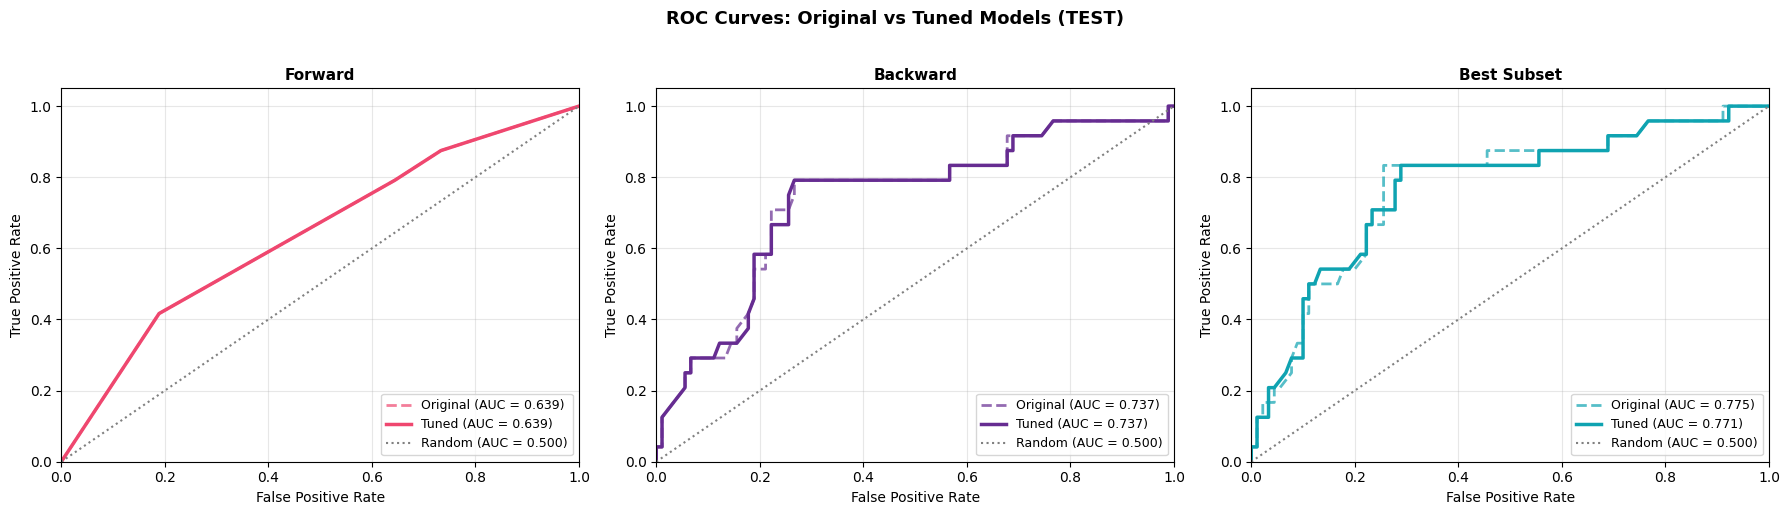

In [678]:
# Visualize comparison: ROC curves for all models on TEST set
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, method_name in enumerate(['forward', 'backward', 'best_subset']):
    if method_name not in tuned_results:
        continue

    ax = axes[idx]
    base_color = colors_roc[method_name]

    # Resolve features by method
    if method_name == 'forward':
        features = fwd_features
    elif method_name == 'backward':
        features = bwd_features
    else:
        features = best_features

    if not features:
        continue

    # Original model ROC (fit on undersampled train, evaluate on test)
    orig_model = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, random_state=1234)
    orig_model.fit(X_train_undersampled[features].values, y_train_undersampled)
    y_prob_orig_test = orig_model.predict_proba(X_test[features].values)[:, 1]

    fpr_orig, tpr_orig, _ = roc_curve(y_test, y_prob_orig_test)
    auc_orig = roc_auc_score(y_test, y_prob_orig_test)
    ax.plot(
        fpr_orig,
        tpr_orig,
        color=base_color,
        lw=2,
        label=f'Original (AUC = {auc_orig:.3f})',
        linestyle='--',
        alpha=0.7
    )

    # Tuned model ROC (use tuned model, evaluate on test)
    tuned_model = tuned_results[method_name]['model']
    y_prob_tuned_test = tuned_model.predict_proba(X_test[features].values)[:, 1]

    fpr_tuned, tpr_tuned, _ = roc_curve(y_test, y_prob_tuned_test)
    auc_tuned = roc_auc_score(y_test, y_prob_tuned_test)
    ax.plot(
        fpr_tuned,
        tpr_tuned,
        color=base_color,
        lw=2.5,
        label=f'Tuned (AUC = {auc_tuned:.3f})'
    )

    # Random classifier
    ax.plot([0, 1], [0, 1], color='gray', lw=1.5, linestyle=':',
            label='Random (AUC = 0.500)')

    ax.set_xlabel('False Positive Rate', fontsize=10)
    ax.set_ylabel('True Positive Rate', fontsize=10)
    ax.set_title(f'{method_name.replace("_", " ").title()}', fontsize=11, fontweight='bold')
    ax.legend(loc='lower right', fontsize=9)
    ax.grid(alpha=0.3)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])

plt.suptitle('ROC Curves: Original vs Tuned Models (TEST)', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

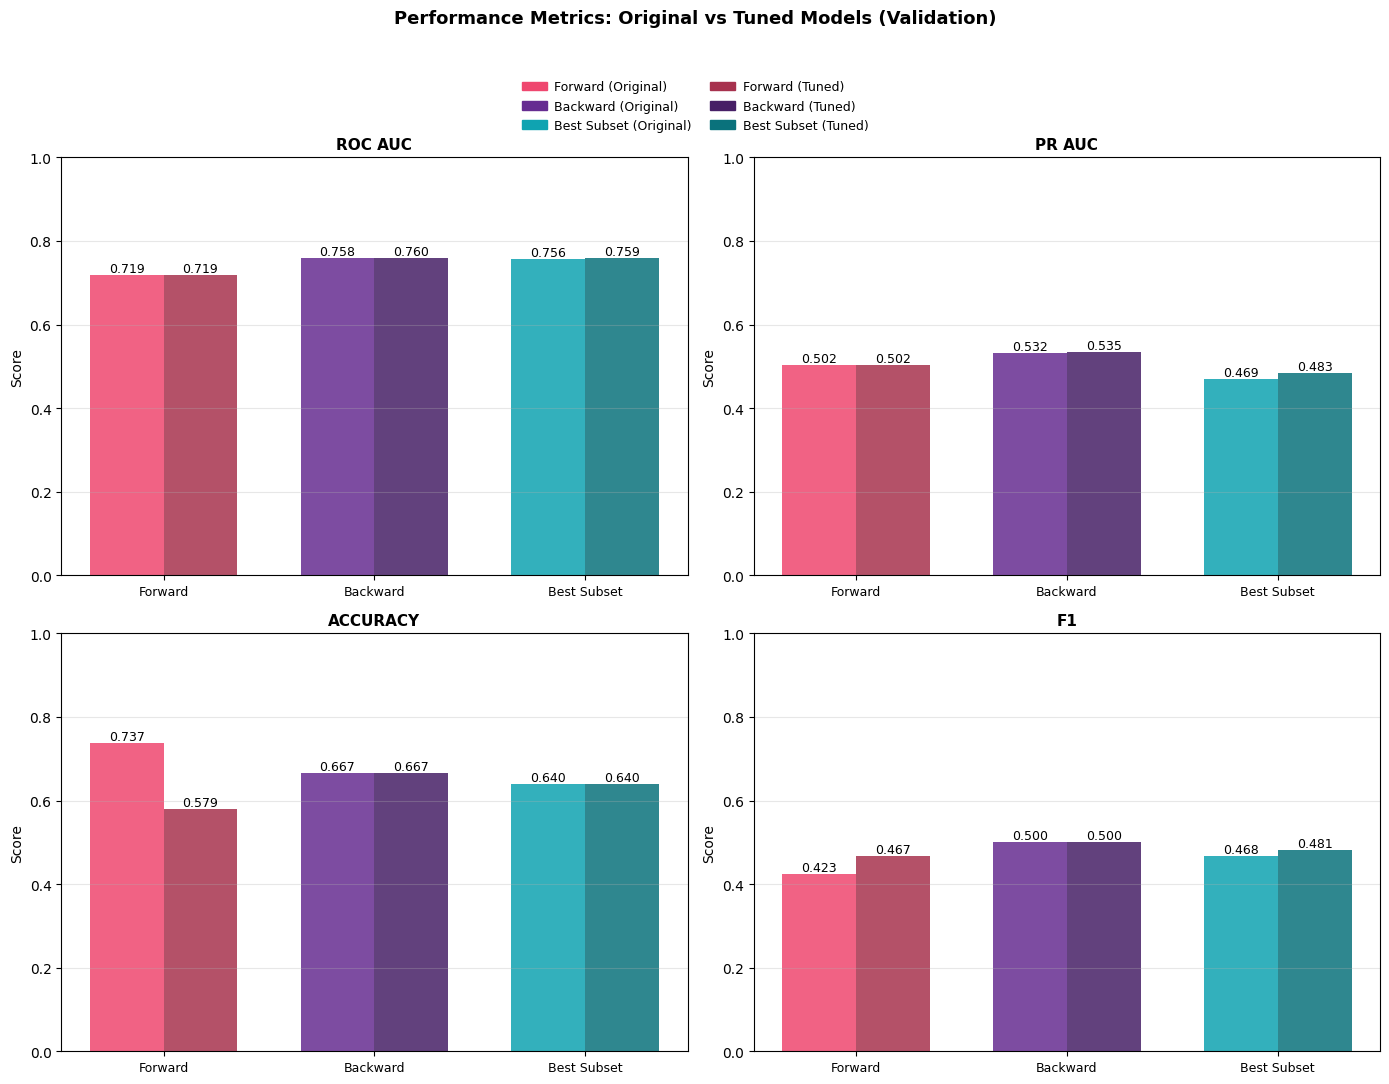

In [679]:
def darken_color(color, factor=0.7):
    rgb = np.array(mcolors.to_rgb(color))
    return mcolors.to_hex(rgb * factor)

# Bar chart comparing metrics across all models (VALIDATION)
metrics_list = ['roc_auc', 'pr_auc', 'accuracy', 'f1']
methods = list(tuned_results.keys())
common_methods = [m for m in methods if m in original_results and m in tuned_results]

if not common_methods:
    raise ValueError("No overlapping methods between original_results and tuned_results.")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Legend handles in requested order
legend_order = ['forward', 'backward', 'best_subset']
legend_handles = []
for m in legend_order:
    if m in common_methods:
        legend_handles.append(Patch(color=colors_roc[m], label=f'{m.replace("_", " ").title()} (Original)'))
for m in legend_order:
    if m in common_methods:
        legend_handles.append(Patch(color=darken_color(colors_roc[m], factor=0.7), label=f'{m.replace("_", " ").title()} (Tuned)'))

for idx, metric in enumerate(metrics_list):
    ax = axes[idx]
    
    x = np.arange(len(common_methods))
    width = 0.35
    
    original_scores = [original_results[m]['metrics'][metric] for m in common_methods]
    tuned_scores = [tuned_results[m]['metrics'][metric] for m in common_methods]
    
    original_colors = [colors_roc[m] for m in common_methods]
    tuned_colors = [darken_color(colors_roc[m], factor=0.7) for m in common_methods]
    
    bars1 = ax.bar(x - width/2, original_scores, width, color=original_colors, alpha=0.85)
    bars2 = ax.bar(x + width/2, tuned_scores, width, color=tuned_colors, alpha=0.85)
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    ax.set_ylabel('Score', fontsize=10)
    ax.set_title(metric.replace('_', ' ').upper(), fontsize=11, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([m.replace('_', ' ').title() for m in common_methods], fontsize=9)
    ax.set_ylim([0, 1.0])
    ax.grid(axis='y', alpha=0.3)

# Single legend for all subplots (3x2 grid)
fig.legend(
    handles=legend_handles,
    loc='upper center',
    ncol=2,
    bbox_to_anchor=(0.5, 1.02),
    fontsize=9,
    frameon=False,
    columnspacing=1.5,
    handletextpad=0.6
)

plt.suptitle('Performance Metrics: Original vs Tuned Models (Validation)', fontsize=13, fontweight='bold', y=1.08)
fig.subplots_adjust(top=0.90)
plt.tight_layout()
plt.show()

## Final Test Evaluation

Report classification metrics and confusion matrices for the final tuned model using the selected operating threshold.

DETAILED EVALUATION: FINAL TUNED MODEL (Backward)

Classification Report (Test Set):
               precision    recall  f1-score   support

No Recurrence      0.919     0.633     0.750        90
   Recurrence      0.365     0.792     0.500        24

     accuracy                          0.667       114
    macro avg      0.642     0.712     0.625       114
 weighted avg      0.803     0.667     0.697       114


Confusion Matrix (Test Set):
[[57 33]
 [ 5 19]]


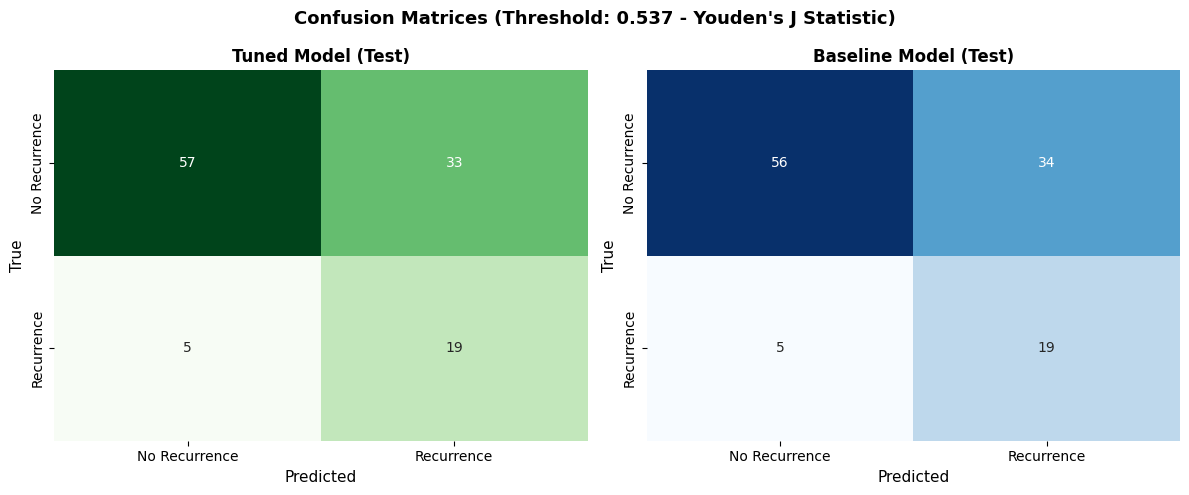

In [680]:
# Detailed classification report and confusion matrix for final tuned model (TEST SET)
print("=" * 80)
print(f"DETAILED EVALUATION: FINAL TUNED MODEL ({final_method.replace('_', ' ').title()})")
print("=" * 80 + "\n")

if 'final_method' not in globals():
    raise ValueError("Final model not defined. Run the tuning/selection cell first.")

y_pred_final_test = (y_prob_final_test >= selected_threshold).astype(int)

print("Classification Report (Test Set):")
print(classification_report(y_test, y_pred_final_test, target_names=['No Recurrence', 'Recurrence'], digits=3))

cm_tuned = confusion_matrix(y_test, y_pred_final_test)
print("\nConfusion Matrix (Test Set):")
print(cm_tuned)

# Plot confusion matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Tuned model confusion matrix
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Greens', cbar=False, ax=ax1,
            xticklabels=['No Recurrence', 'Recurrence'],
            yticklabels=['No Recurrence', 'Recurrence'])
ax1.set_xlabel('Predicted', fontsize=11)
ax1.set_ylabel('True', fontsize=11)
ax1.set_title('Tuned Model (Test)', fontsize=12, fontweight='bold')

# Baseline model confusion matrix for comparison (same threshold)
y_prob_baseline_test = baseline_model.predict_proba(X_test[final_features].values)[:, 1]
y_pred_baseline_test = (y_prob_baseline_test >= selected_threshold).astype(int)
cm_orig = confusion_matrix(y_test, y_pred_baseline_test)
sns.heatmap(cm_orig, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax2,
            xticklabels=['No Recurrence', 'Recurrence'],
            yticklabels=['No Recurrence', 'Recurrence'])
ax2.set_xlabel('Predicted', fontsize=11)
ax2.set_ylabel('True', fontsize=11)
ax2.set_title('Baseline Model (Test)', fontsize=12, fontweight='bold')

plt.suptitle(f'Confusion Matrices (Threshold: {selected_threshold:.3f} - {selected_threshold_label})',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()